## OTTO – Multi-Objective Recommender System

## 1. Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
competition_dataset_directory = pathlib.Path('../input/otto-recommender-system')
pickled_dataset_directory = pathlib.Path('../input/otto-multi-objective-recommender-system-pickle')

df_train = pd.read_pickle(pickled_dataset_directory / 'train.pkl')
df_test = pd.read_pickle(pickled_dataset_directory / 'test.pkl')

print(f'Training Shape: {df_train.shape} - Memory Usage: {df_train.memory_usage().sum() / 1024 ** 2:.2f} MB')
print(f'Test Shape: {df_test.shape} - Memory Usage: {df_test.memory_usage().sum() / 1024 ** 2:.2f} MB')

Training Shape: (216716096, 4) - Memory Usage: 3513.50 MB
Test Shape: (6928123, 4) - Memory Usage: 112.32 MB


## 2. Introduction

This is a large dataset of e-commerce sessions. Sessions consist of user events such as clicking to a product, adding a product to cart or ordering a product. Each session belongs to a unique user and duration of sessions are different from each other.

* `session`: unique ID of the user session
* `aid`: unique ID of the product
* `ts`: timestamp of the event
* `type`: category of the event

It is a multi-objective ranking problem since there are 3 categories (click, cart, order) to recommend for each session. Recommendations for each category are evaluated on recall@20 and scores are multiplied with their corresponding weights.

* **216.7M** events in training set and **6.9M** events in test set
* **12.8M** sessions in training set and **1.6M** sessions in test set
* **1.8M** products in training set and **783K** products in test set
* **194.7M** clicks in training set and **6.2M** clicks in test set
* **16.8M** carts in training set and **570K** carts in test set
* **5M** orders in training set and **65K** orders in test set

In [3]:
train_events = df_train.shape[0]
test_events = df_test.shape[0]
print(f'Number of Events - Training: {train_events} | Test: {test_events}')

train_unique_sessions = df_train['session'].unique()
test_unique_sessions = df_test['session'].unique()
print(f'Number of Unique Sessions - Training: {len(train_unique_sessions)} | Test: {len(test_unique_sessions)}')
del train_unique_sessions, test_unique_sessions

train_unique_aids = df_train['aid'].unique()
test_unique_aids = df_test['aid'].unique()
overlapping_aids = set(train_unique_aids).intersection(set(test_unique_aids))
print(f'Number of Unique Products - Training: {len(train_unique_aids)} | Test: {len(test_unique_aids)} - ({len(overlapping_aids)} Overlapping Products)')
del train_unique_aids, test_unique_aids, overlapping_aids

train_clicks = df_train[df_train['type'] == 0].shape[0]
test_clicks = df_test[df_test['type'] == 0].shape[0]
print(f'Number of Clicks - Training: {train_clicks} | Test: {test_clicks}')

train_carts = df_train[df_train['type'] == 1].shape[0]
test_carts = df_test[df_test['type'] == 1].shape[0]
print(f'Number of Carts - Training: {train_carts} | Test: {test_carts}')

train_orders = df_train[df_train['type'] == 2].shape[0]
test_orders = df_test[df_test['type'] == 2].shape[0]
print(f'Number of Orders - Training: {train_orders} | Test: {test_orders}')

Number of Events - Training: 216716096 | Test: 6928123
Number of Unique Sessions - Training: 12899779 | Test: 1671803
Number of Unique Products - Training: 1855603 | Test: 783486 - (783486 Overlapping Products)
Number of Clicks - Training: 194720954 | Test: 6292632
Number of Carts - Training: 16896191 | Test: 570011
Number of Orders - Training: 5098951 | Test: 65480


In [4]:
train_start = df_train['ts'].min().strftime('%Y.%m.%d %X')
train_end = df_train['ts'].max().strftime('%Y.%m.%d %X')
test_start = df_test['ts'].min().strftime('%Y.%m.%d %X')
test_end = df_test['ts'].max().strftime('%Y.%m.%d %X')
print(f'Events Time Range\nTraining: {train_start} - {train_end}\nTest: {test_start} - {test_end}')

Events Time Range
Training: 2022.07.31 22:00:00 - 2022.08.28 21:59:59
Test: 2022.08.28 22:00:00 - 2022.09.04 21:59:51


Training and test set are split by time. Training set is 4 weeks of user events and test set is the following week after training set. There aren't any overlapping events between training and test set because some of the training set events are trimmed in order to prevent leakage. Proportions of event types are similar in training and test set which can be seen from the visualization below.

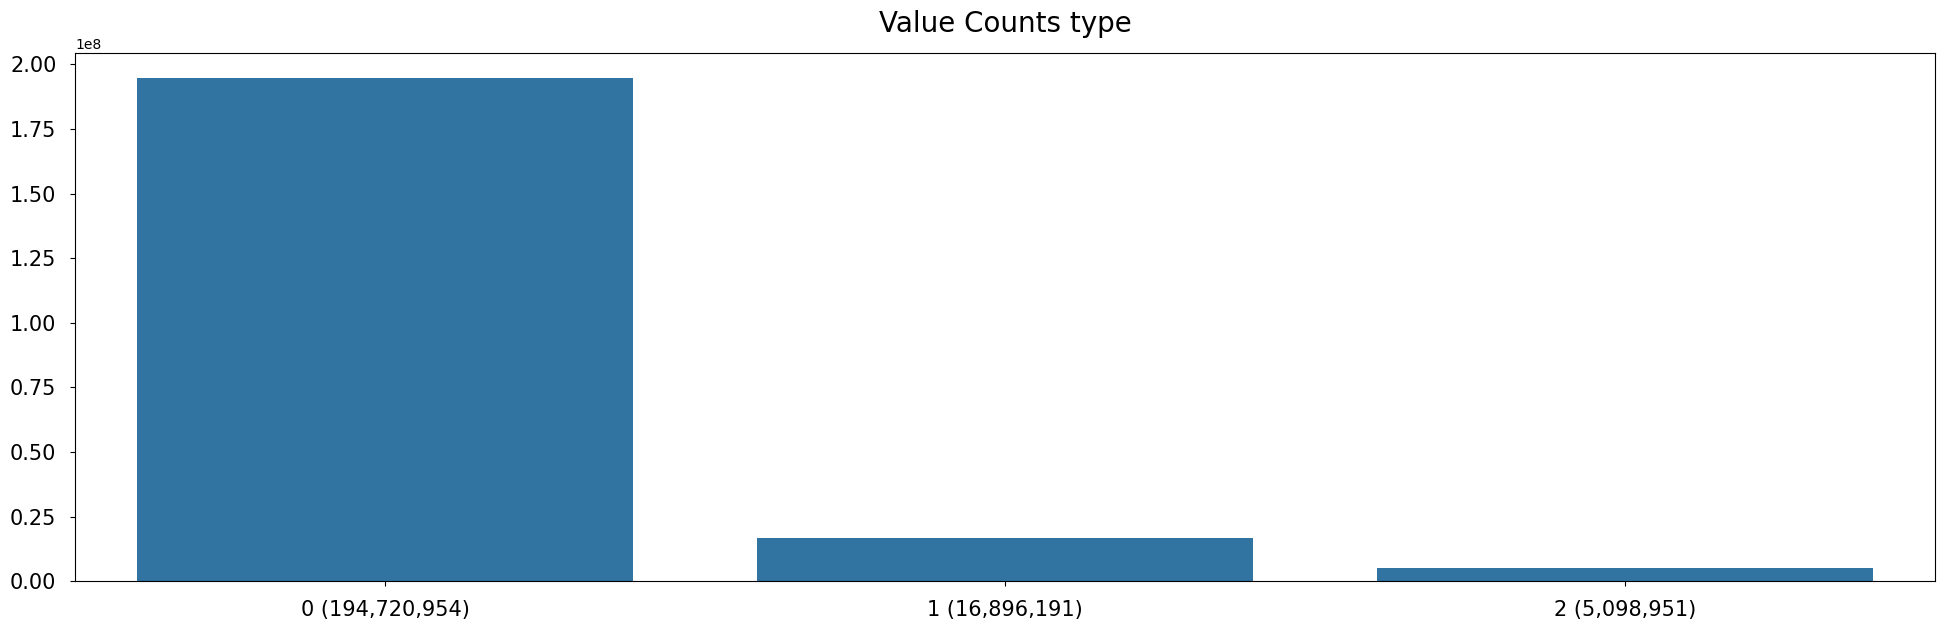

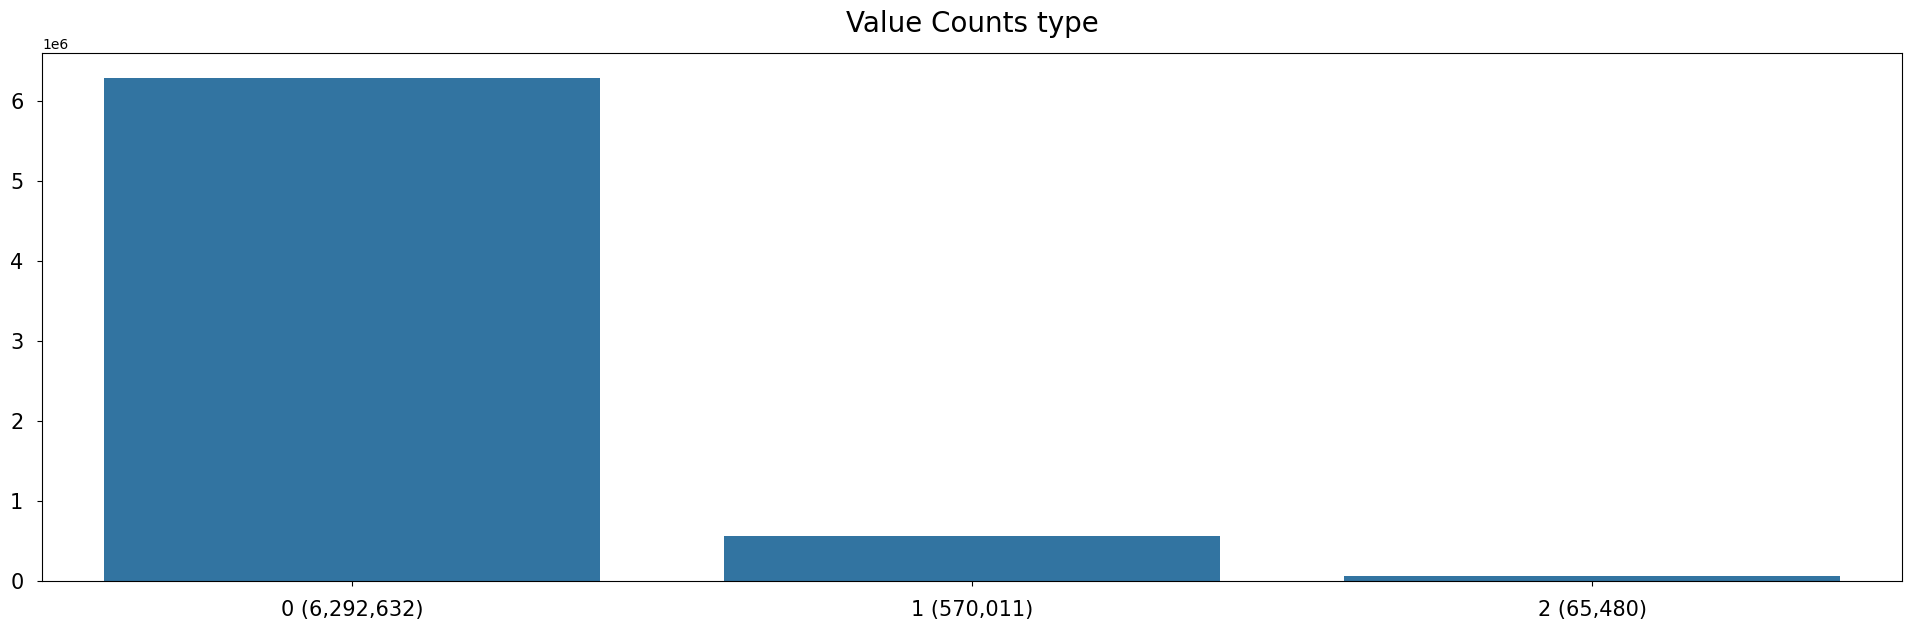

In [5]:
def visualize_categorical_feature_distribution(df, feature, path=None):

    """
    Visualize distribution of given categorical column in given dataframe
    
    Parameters
    ----------
    df: pandas.DataFrame of shape (n_samples, 4)
        Dataframe with session, aid, ts, type columns
        
    feature: str
        Name of the categorical feature
    
    path: path-like str or None
        Path of the output file or None (if path is None, plot is displayed with selected backend)
    """

    fig, ax = plt.subplots(figsize=(24, df[feature].value_counts().shape[0] + 4), dpi=100)
    sns.barplot(
        y=df[feature].value_counts().values,
        x=df[feature].value_counts().index,
        color='tab:blue',
        ax=ax
    )
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([
        f'{x} ({value_count:,})' for value_count, x in zip(
            df[feature].value_counts().values,
            df[feature].value_counts().index
        )
    ])
    ax.tick_params(axis='x', labelsize=15, pad=10)
    ax.tick_params(axis='y', labelsize=15, pad=10)
    ax.set_title(f'Value Counts {feature}', size=20, pad=15)

    if path is None:
        plt.show()
    else:
        plt.savefig(path)
        plt.close(fig)


visualize_categorical_feature_distribution(df=df_train, feature='type')
visualize_categorical_feature_distribution(df=df_test, feature='type')

## 3. Users and Products

As we already know, there are 12.8M unique users (sessions) in training set and 1.6m unique sessions in test set. However, their statistics are also different between training and test set. In training set, mean session duration is 4 times longer than test set. Shortest session in training set is 2 because it wouldn't be possible to create ground-truth on single event sessions. Longest session in training set is 500 which looks like a threshold for trimming extremely long sessions.

Discrepancy in session statistics may not be a problem because training set is 4 weeks while test set is only a single week. Mean session duration being 4 times longer in training set is also an artifact of that.

Distributions of session durations can be seen from the visualization below. Both densities are on log scale for interpretability.

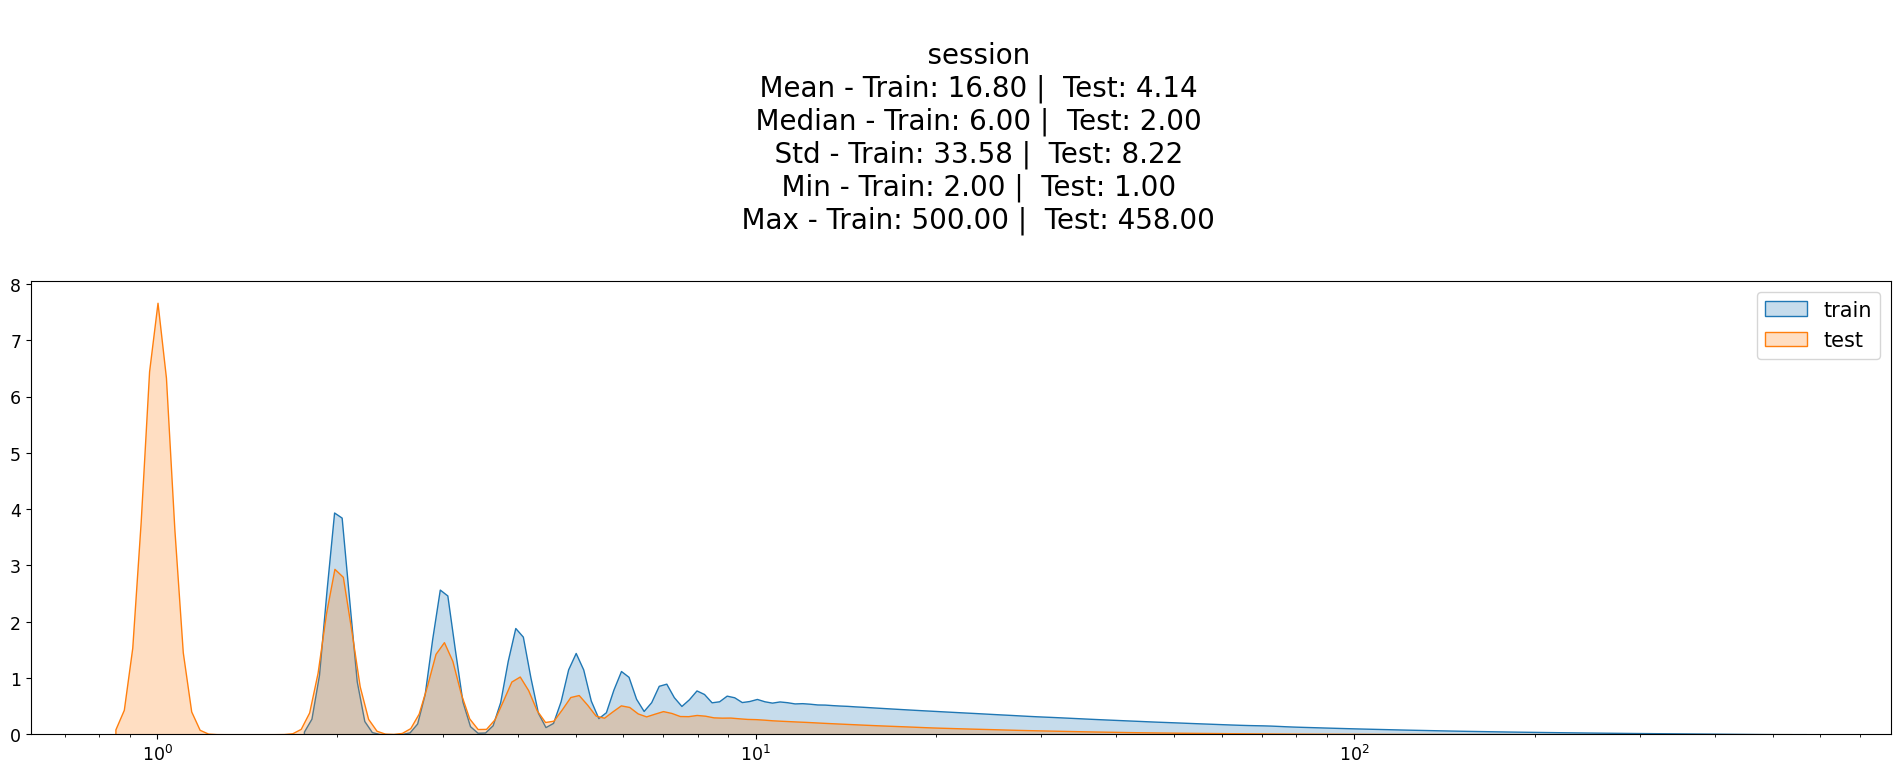

In [6]:
def visualize_continuous_feature_distribution(df_train, df_test, feature, path=None):

    """
    Visualize distribution of given continuous column in given dataframe
    
    Parameters
    ----------
    df_train: pandas.DataFrame of shape (n_samples, 4)
        Training dataframe with session, aid, ts, type columns
        
    df_test: pandas.DataFrame of shape (n_samples, 4)
        Test dataframe with session, aid, ts, type columns
        
    feature: str
        Name of the continuous feature
    
    path: path-like str or None
        Path of the output file or None (if path is None, plot is displayed with selected backend)
    """
    
    fig, ax = plt.subplots(figsize=(24, 6), dpi=100)
    sns.kdeplot(df_train[feature], label='train', fill=True, log_scale=True, ax=ax)
    sns.kdeplot(df_test[feature], label='test', fill=True, log_scale=True, ax=ax)
    ax.tick_params(axis='x', labelsize=12.5)
    ax.tick_params(axis='y', labelsize=12.5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend(prop={'size': 15})
    title = f'''
    {feature}
    Mean - Train: {df_train[feature].mean():.2f} |  Test: {df_test[feature].mean():.2f}
    Median - Train: {df_train[feature].median():.2f} |  Test: {df_test[feature].median():.2f}
    Std - Train: {df_train[feature].std():.2f} |  Test: {df_test[feature].std():.2f}
    Min - Train: {df_train[feature].min():.2f} |  Test: {df_test[feature].min():.2f}
    Max - Train: {df_train[feature].max():.2f} |  Test: {df_test[feature].max():.2f}
    '''
    ax.set_title(title, size=20, pad=15)
    
    if path is None:
        plt.show()
    else:
        plt.savefig(path)
        plt.close(fig)

    
df_train_session_counts = df_train.groupby('session')[['session']].count()
df_test_session_counts = df_test.groupby('session')[['session']].count()
visualize_continuous_feature_distribution(df_train=df_train_session_counts, df_test=df_test_session_counts, feature='session')
del df_train_session_counts, df_test_session_counts

There are 1.8M unique products (aids) in training set and 783K unique aids in test set. aids in test set are a subset of aids in training set so there aren't any unseen aid in test set. Distribution of aid occurences is different in training and test set as well because of the previously mentioned reason. Training set aid occurences distribution is more normal while test set aid occurences distribution is multi-modal which could be an artifact of session truncation.

Distributions of aid occurences can be seen from the visualization below. Both densities are on log scale for interpretability.

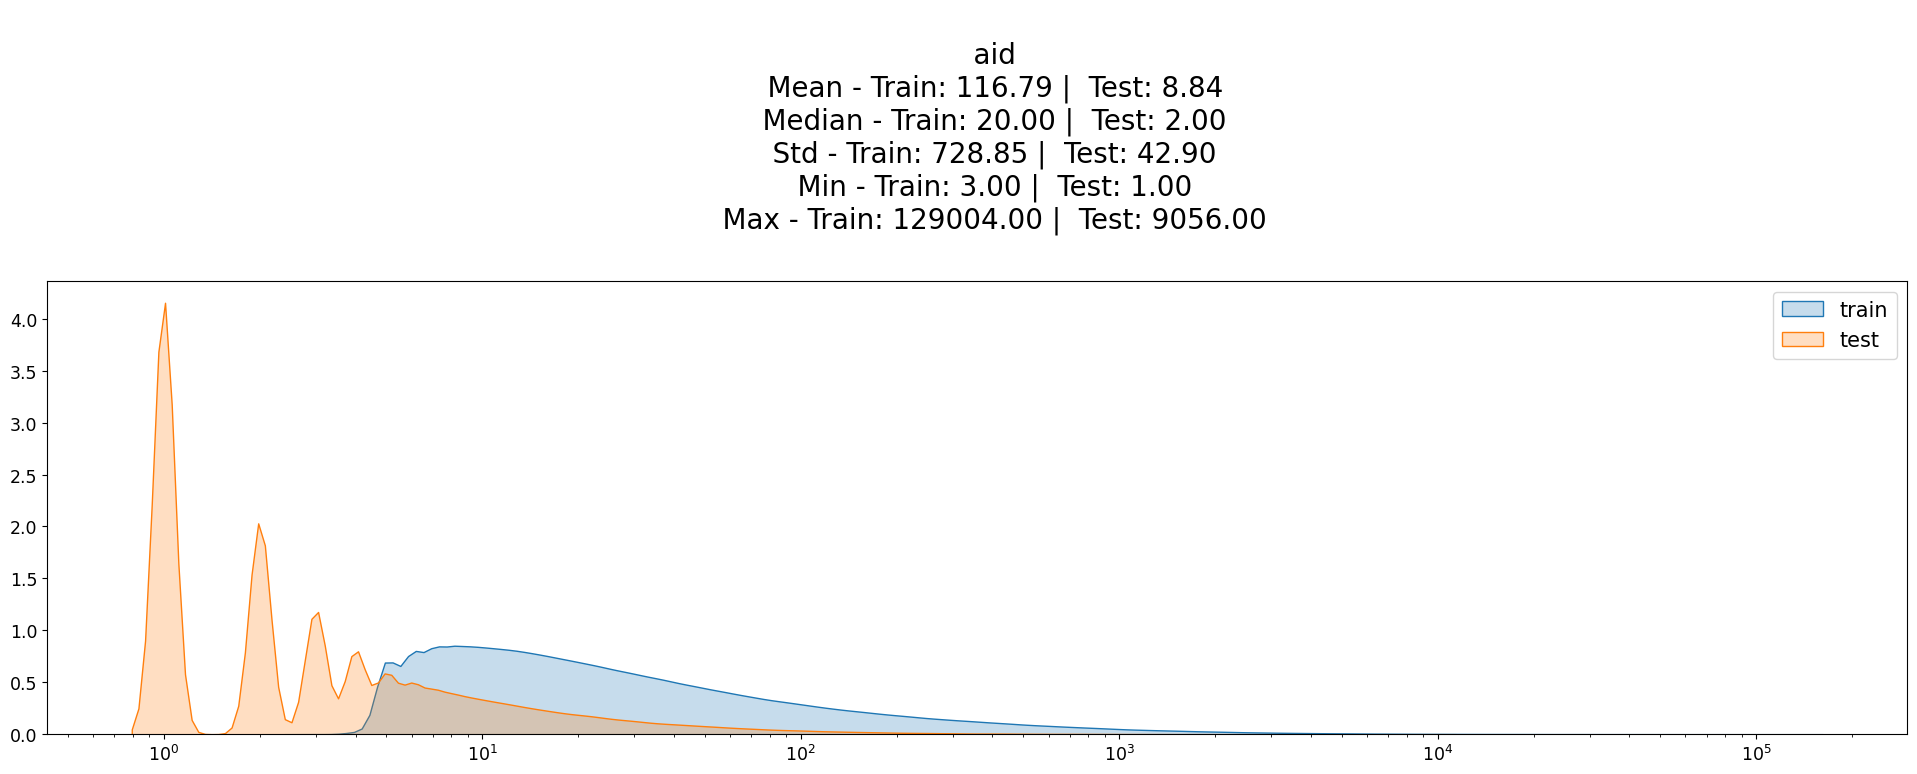

In [7]:
df_train_aid_counts = df_train.groupby('aid')[['aid']].count()
df_test_aid_counts = df_test.groupby('aid')[['aid']].count()
visualize_continuous_feature_distribution(df_train=df_train_aid_counts, df_test=df_test_aid_counts, feature='aid')

In [8]:
df_train_aid_counts = df_train_aid_counts.rename(columns={'aid': 'count'}).reset_index()
df_test_aid_counts = df_test_aid_counts.rename(columns={'aid': 'count'}).reset_index()
df_all_aid_counts = pd.concat((df_train_aid_counts, df_test_aid_counts), axis=0, ignore_index=True).reset_index(drop=True)
df_all_aid_counts = df_all_aid_counts.groupby('aid')['count'].sum().reset_index()

df_train_aid_counts.sort_values(by='count', ascending=False, inplace=True)
df_test_aid_counts.sort_values(by='count', ascending=False, inplace=True)
df_all_aid_counts.sort_values(by='count', ascending=False, inplace=True)

train_20_most_frequent_aids = df_train_aid_counts.set_index('aid').head(20).to_dict()['count']
test_20_most_frequent_aids = df_test_aid_counts.set_index('aid').head(20).to_dict()['count']
all_20_most_frequent_aids = df_all_aid_counts.set_index('aid').head(20).to_dict()['count']

del df_train_aid_counts, df_test_aid_counts, df_all_aid_counts

aid frequencies in training and test are very similar. There are minor differences between them since test set is almost 20 times smaller than training set. Computing aid frequencies on concatenated training and test set would be more reliable if aid frequencies are utilized in any way.

Top 20 most frequent aids are visualized for training, test and training + test sets below. X axis is the frequency and y axis labels are aid and its frequency inside parentheses.

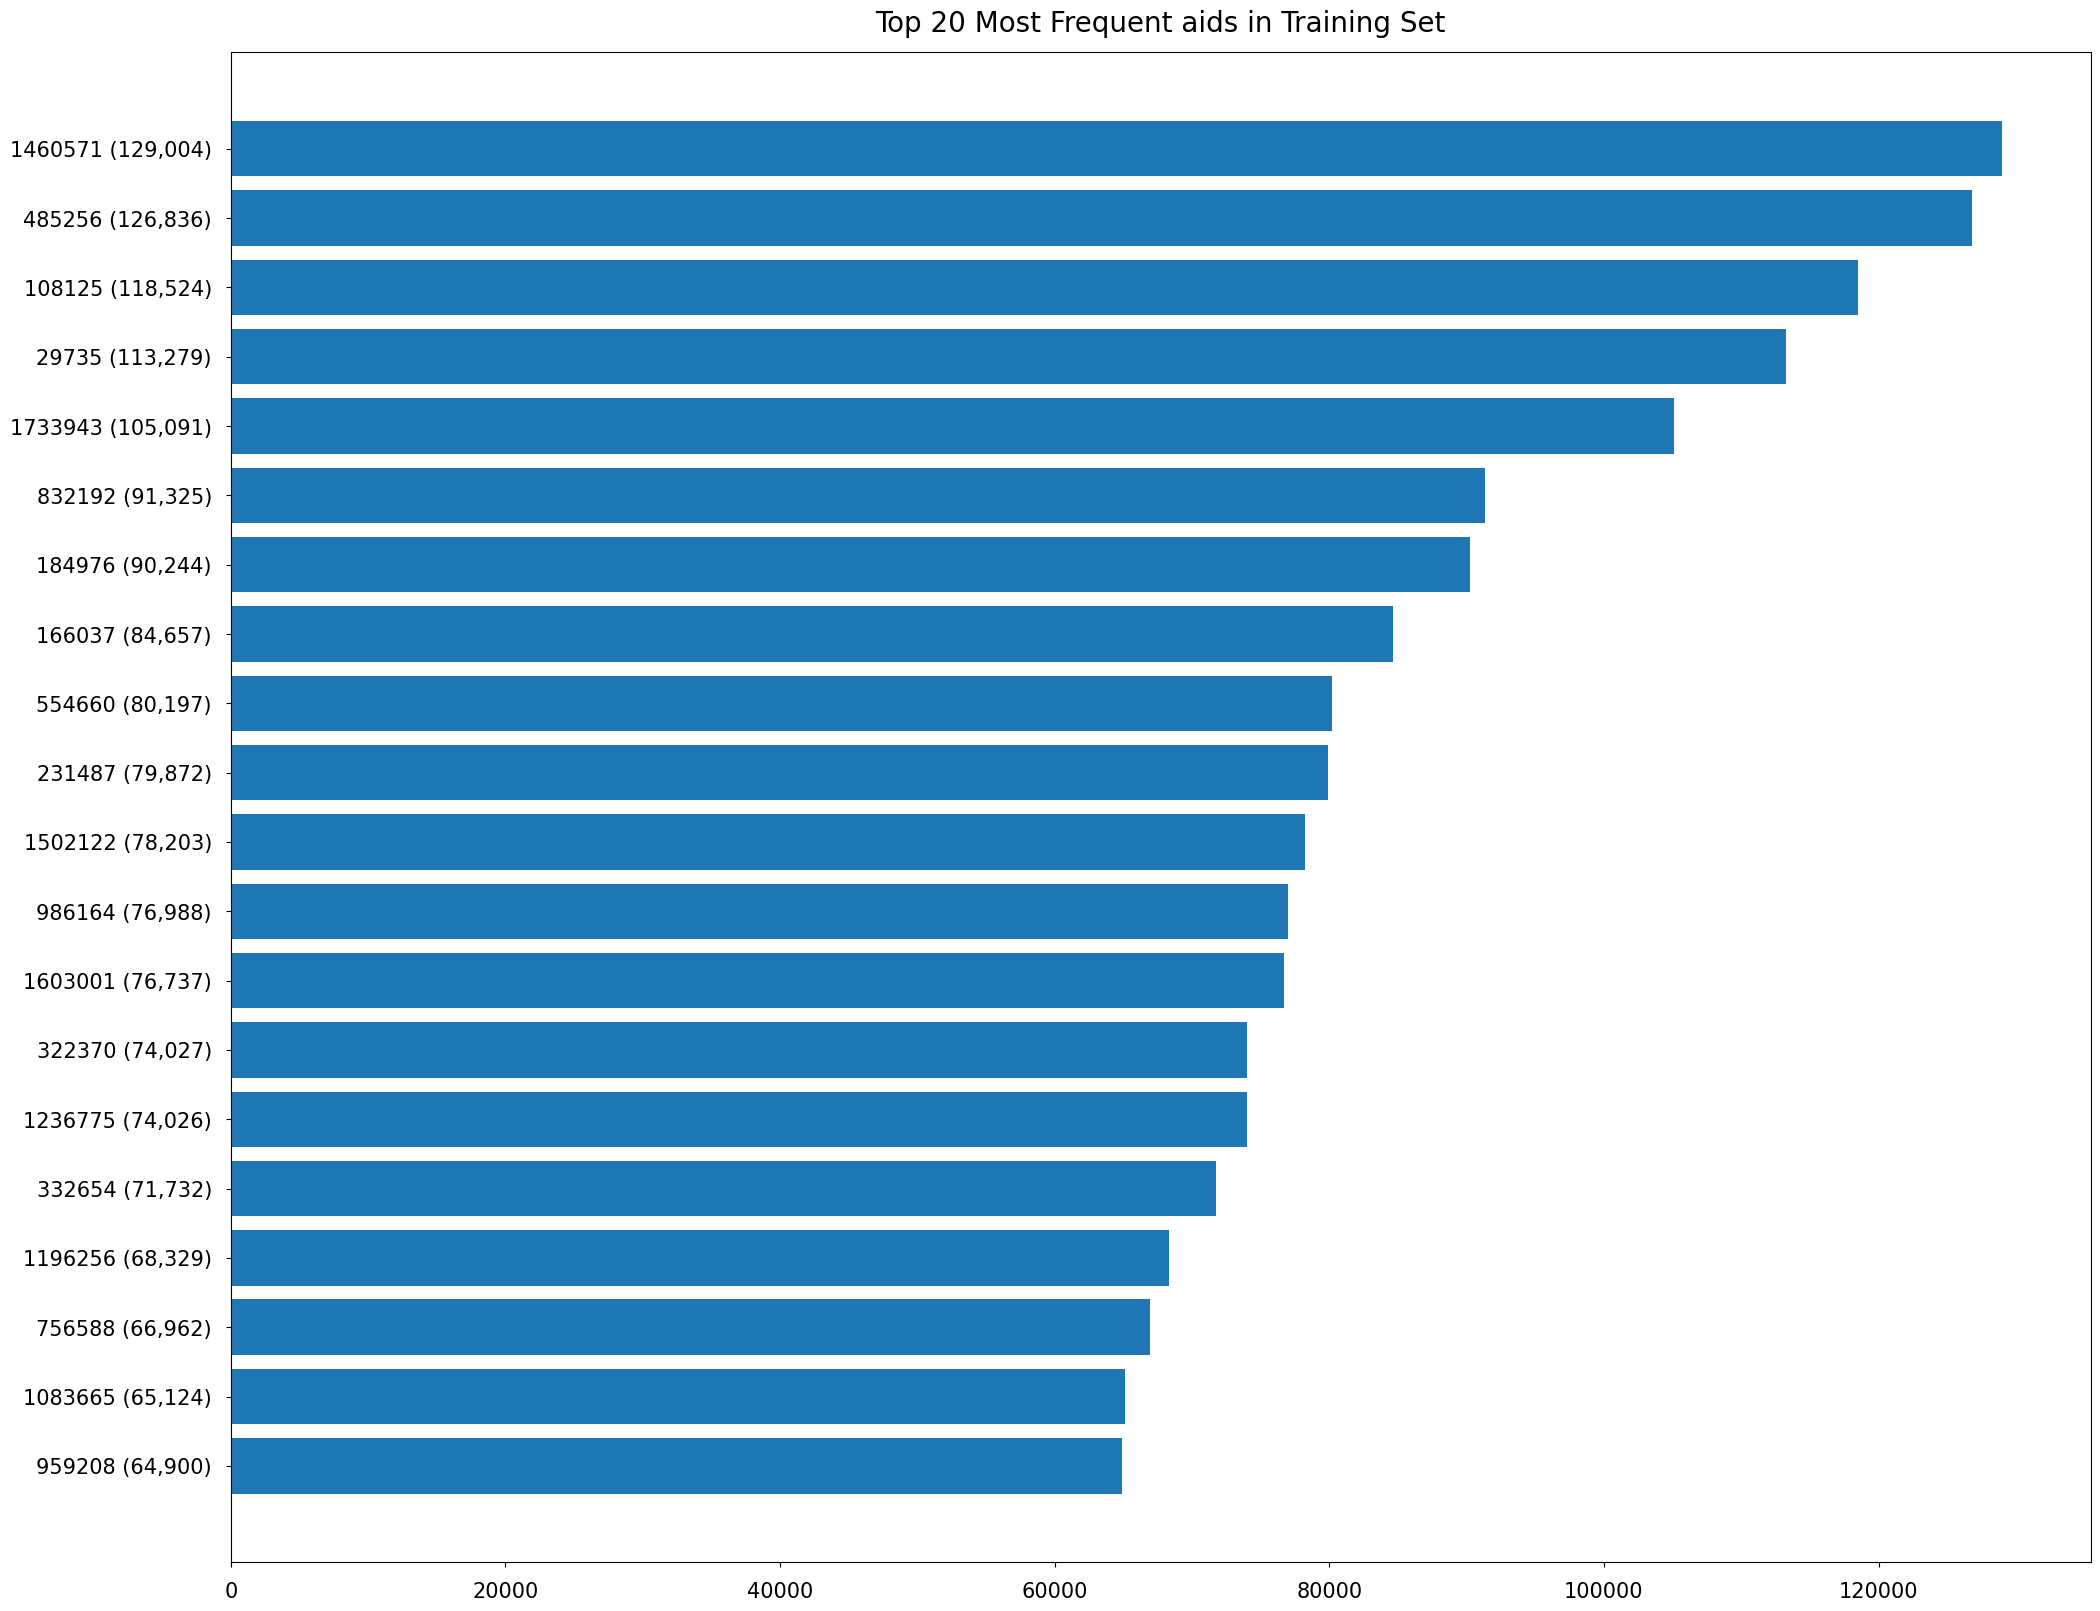

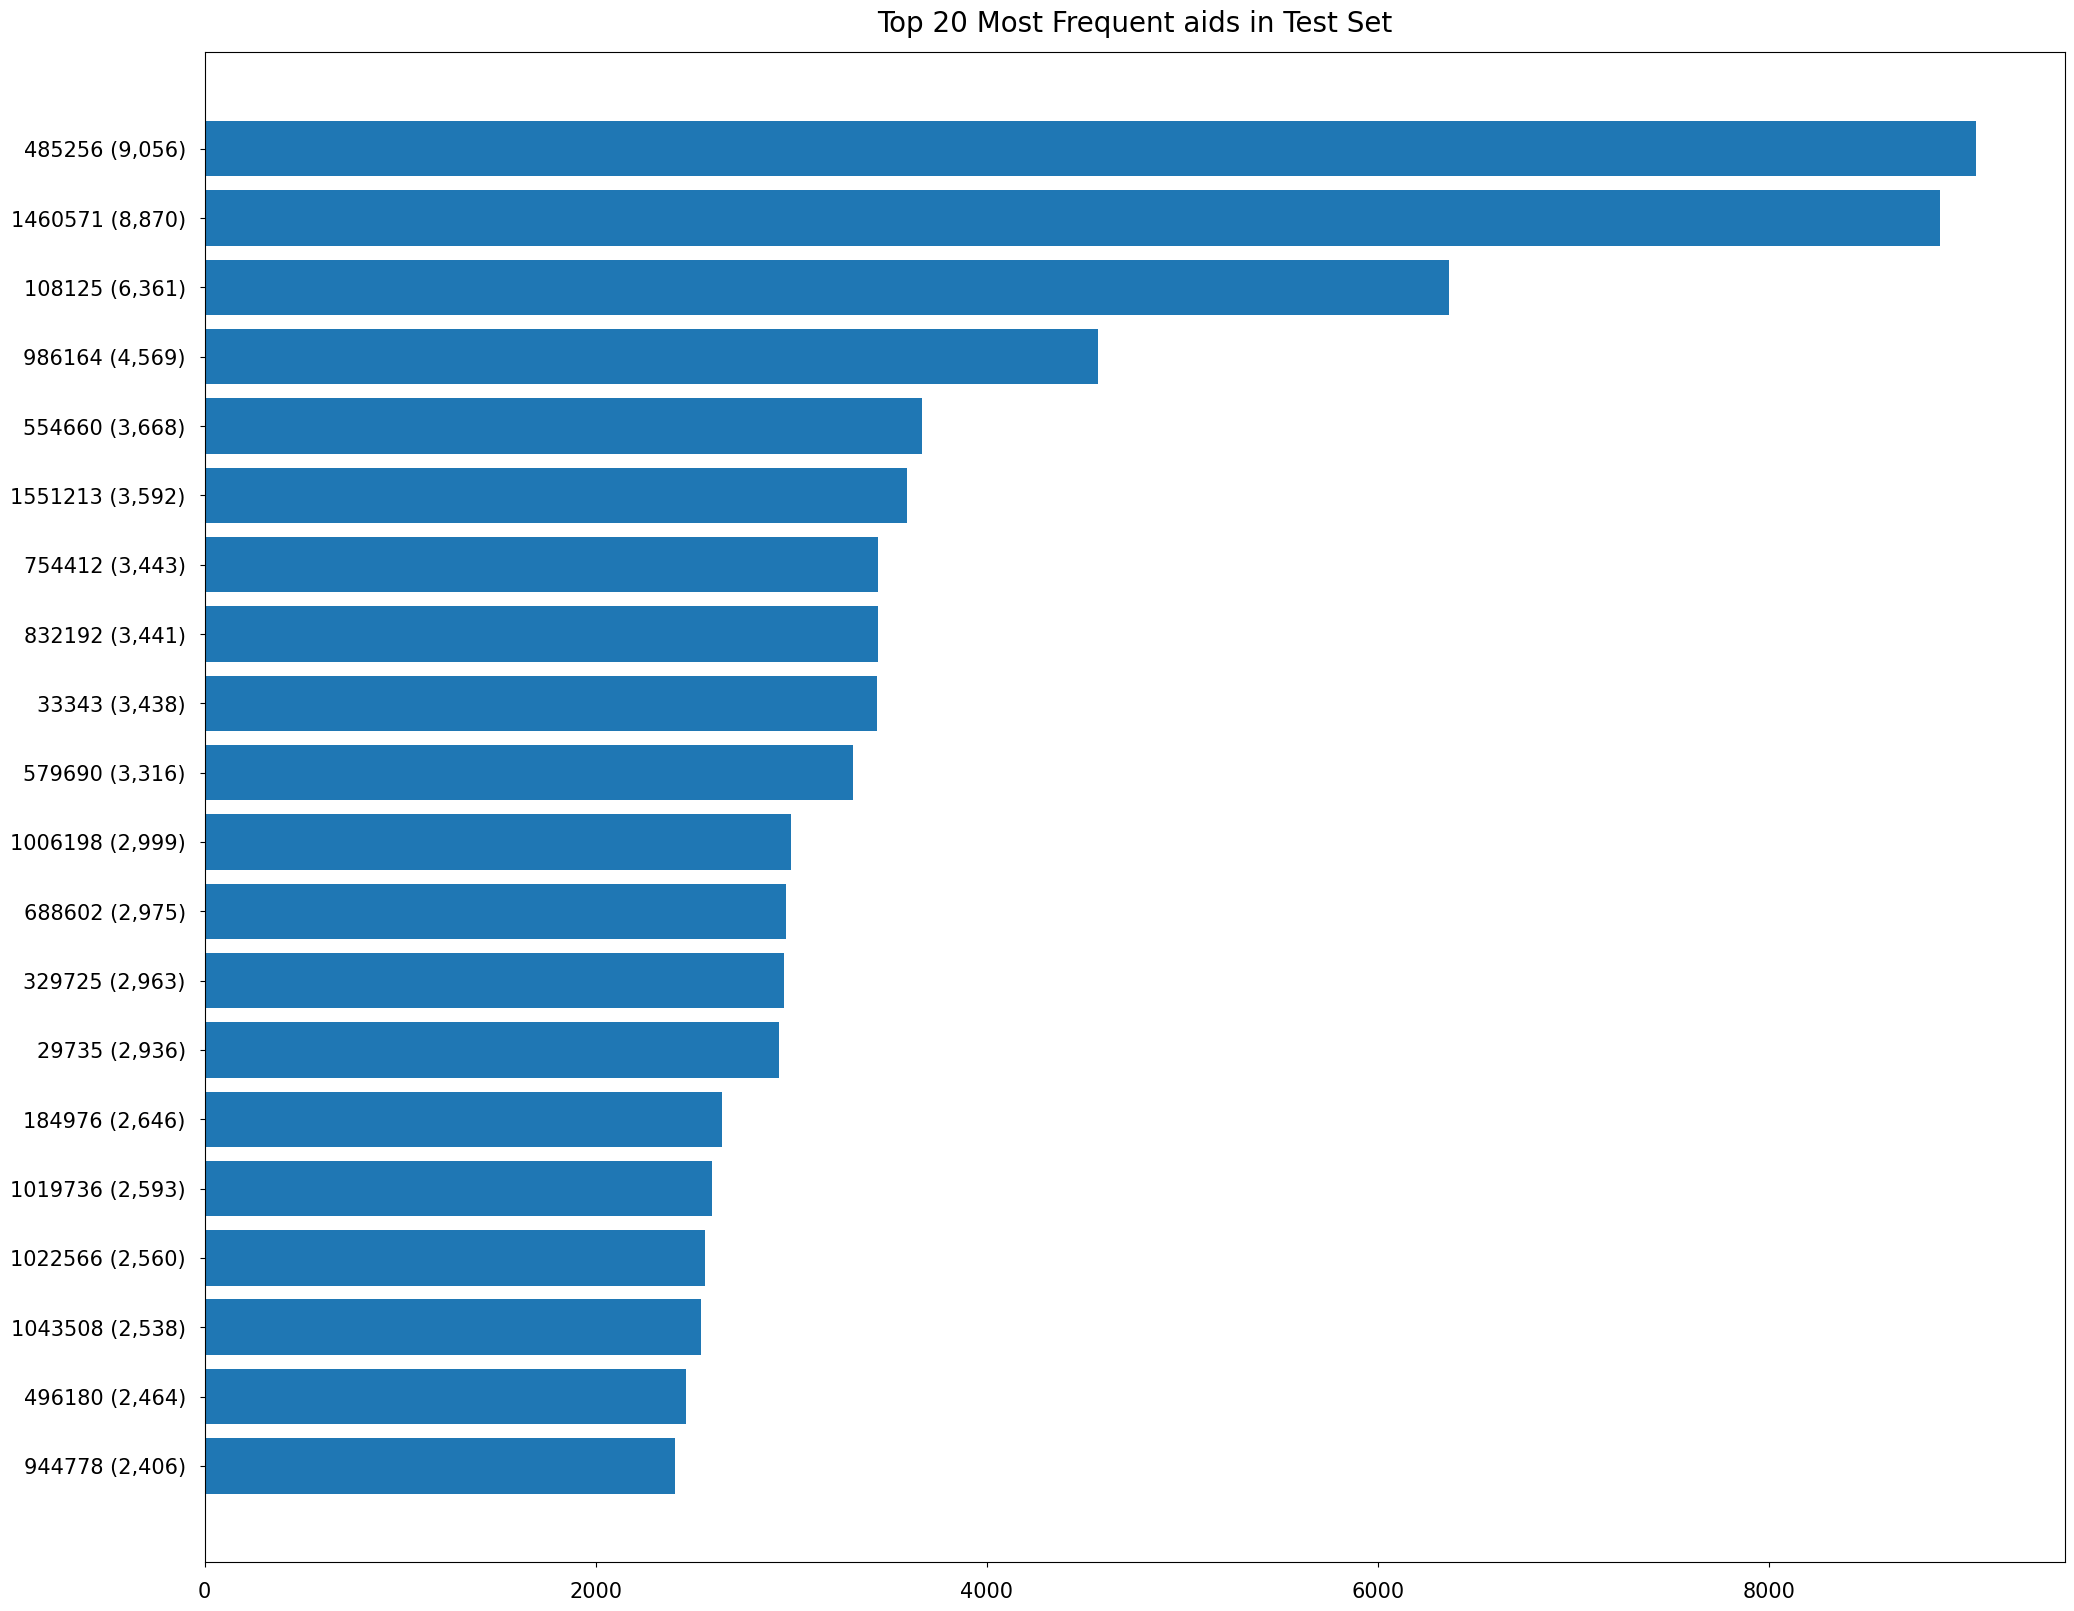

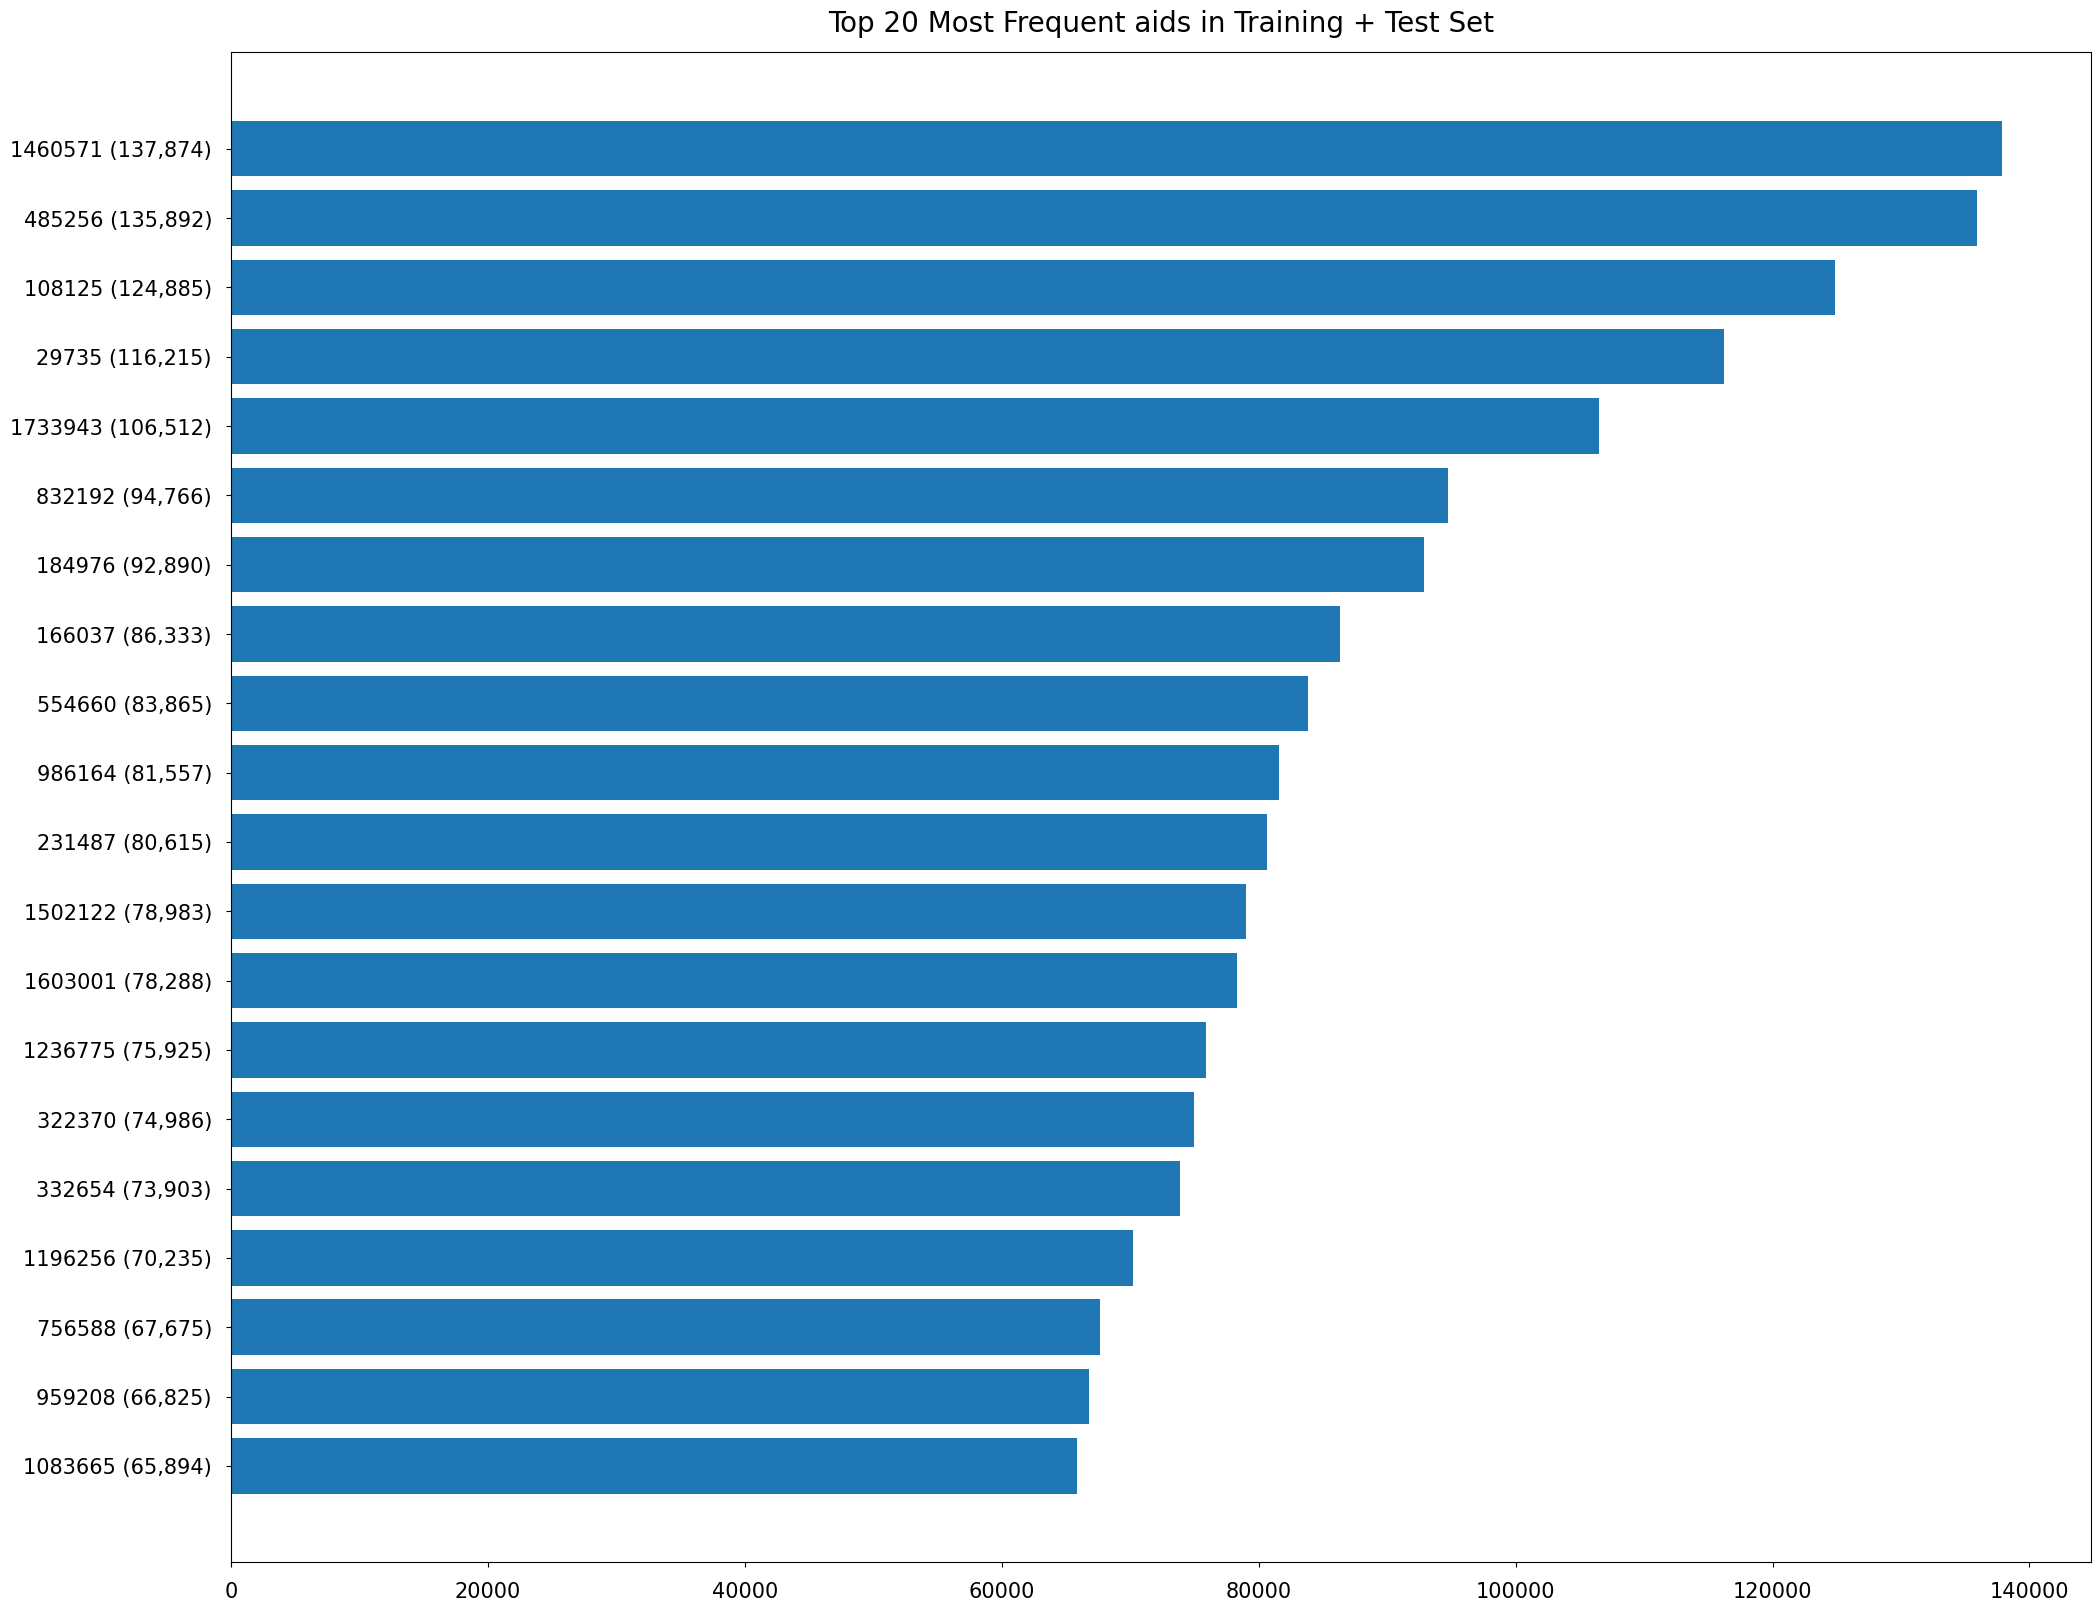

In [9]:
def visualize_aid_frequencies(aid_frequencies, title, path=None):
    
    """
    Visualize aids and their frequencies in given dictionary
    
    Parameters
    ----------
    aid_frequencies: dict
        Dictionary of aids and their frequencies
        
    title: str
        Title of the plot
    
    path: path-like str or None
        Path of the output file or None (if path is None, plot is displayed with selected backend)
    """
    
    fig, ax = plt.subplots(figsize=(24, 20), dpi=100)
    ax.barh(range(len(aid_frequencies)), aid_frequencies.values(), align='center')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticks(range(len(aid_frequencies)))
    ax.set_yticklabels([f'{x} ({value_count:,})' for x, value_count in aid_frequencies.items()])
    ax.tick_params(axis='x', labelsize=15, pad=10)
    ax.tick_params(axis='y', labelsize=15, pad=10)
    ax.set_title(title, size=20, pad=15)
    plt.gca().invert_yaxis()

    if path is None:
        plt.show()
    else:
        plt.savefig(path)
        plt.close(fig)


visualize_aid_frequencies(
    aid_frequencies=train_20_most_frequent_aids,
    title='Top 20 Most Frequent aids in Training Set'
)
visualize_aid_frequencies(
    aid_frequencies=test_20_most_frequent_aids,
    title='Top 20 Most Frequent aids in Test Set'
)
visualize_aid_frequencies(
    aid_frequencies=all_20_most_frequent_aids,
    title='Top 20 Most Frequent aids in Training + Test Set'
)

aid frequencies are also different between clicks, carts and orders. global aid frequencies are closer to click aid frequencies because clicks dominate the event types.

In [10]:
df_train_aids_by_types  = df_train.groupby(['type', 'aid'])[['aid']].count()
df_test_aids_by_types  = df_test.groupby(['type', 'aid'])[['aid']].count()
df_train_click_aid_counts = df_train_aids_by_types.loc[0].rename(columns={'aid': 'count'}).reset_index()
df_train_cart_aid_counts = df_train_aids_by_types.loc[1].rename(columns={'aid': 'count'}).reset_index()
df_train_order_aid_counts = df_train_aids_by_types.loc[2].rename(columns={'aid': 'count'}).reset_index()
df_test_click_aid_counts = df_test_aids_by_types.loc[0].rename(columns={'aid': 'count'}).reset_index()
df_test_cart_aid_counts = df_test_aids_by_types.loc[1].rename(columns={'aid': 'count'}).reset_index()
df_test_order_aid_counts = df_test_aids_by_types.loc[2].rename(columns={'aid': 'count'}).reset_index()
df_all_click_aid_counts = pd.concat((df_train_click_aid_counts, df_test_click_aid_counts), axis=0, ignore_index=True).reset_index(drop=True)
df_all_click_aid_counts = df_all_click_aid_counts.groupby('aid')['count'].sum().reset_index()
df_all_cart_aid_counts = pd.concat((df_train_cart_aid_counts, df_test_cart_aid_counts), axis=0, ignore_index=True).reset_index(drop=True)
df_all_cart_aid_counts = df_all_cart_aid_counts.groupby('aid')['count'].sum().reset_index()
df_all_order_aid_counts = pd.concat((df_train_order_aid_counts, df_test_order_aid_counts), axis=0, ignore_index=True).reset_index(drop=True)
df_all_order_aid_counts = df_all_order_aid_counts.groupby('aid')['count'].sum().reset_index()

df_train_click_aid_counts.sort_values(by='count', ascending=False, inplace=True)
df_test_click_aid_counts.sort_values(by='count', ascending=False, inplace=True)
df_all_click_aid_counts.sort_values(by='count', ascending=False, inplace=True)

df_train_cart_aid_counts.sort_values(by='count', ascending=False, inplace=True)
df_test_cart_aid_counts.sort_values(by='count', ascending=False, inplace=True)
df_all_cart_aid_counts.sort_values(by='count', ascending=False, inplace=True)

df_train_order_aid_counts.sort_values(by='count', ascending=False, inplace=True)
df_test_order_aid_counts.sort_values(by='count', ascending=False, inplace=True)
df_all_order_aid_counts.sort_values(by='count', ascending=False, inplace=True)

train_20_most_frequent_click_aids = df_train_click_aid_counts.set_index('aid').head(20).to_dict()['count']
test_20_most_frequent_click_aids = df_test_click_aid_counts.set_index('aid').head(20).to_dict()['count']
all_20_most_frequent_click_aids = df_all_click_aid_counts.set_index('aid').head(20).to_dict()['count']

train_20_most_frequent_cart_aids = df_train_cart_aid_counts.set_index('aid').head(20).to_dict()['count']
test_20_most_frequent_cart_aids = df_test_cart_aid_counts.set_index('aid').head(20).to_dict()['count']
all_20_most_frequent_cart_aids = df_all_cart_aid_counts.set_index('aid').head(20).to_dict()['count']

train_20_most_frequent_order_aids = df_train_order_aid_counts.set_index('aid').head(20).to_dict()['count']
test_20_most_frequent_order_aids = df_test_order_aid_counts.set_index('aid').head(20).to_dict()['count']
all_20_most_frequent_order_aids = df_all_order_aid_counts.set_index('aid').head(20).to_dict()['count']

Top 20 most frequent click aids are visualized for training, test and training + test sets below. X axis is the frequency and y axis labels are aid and its frequency inside parentheses.

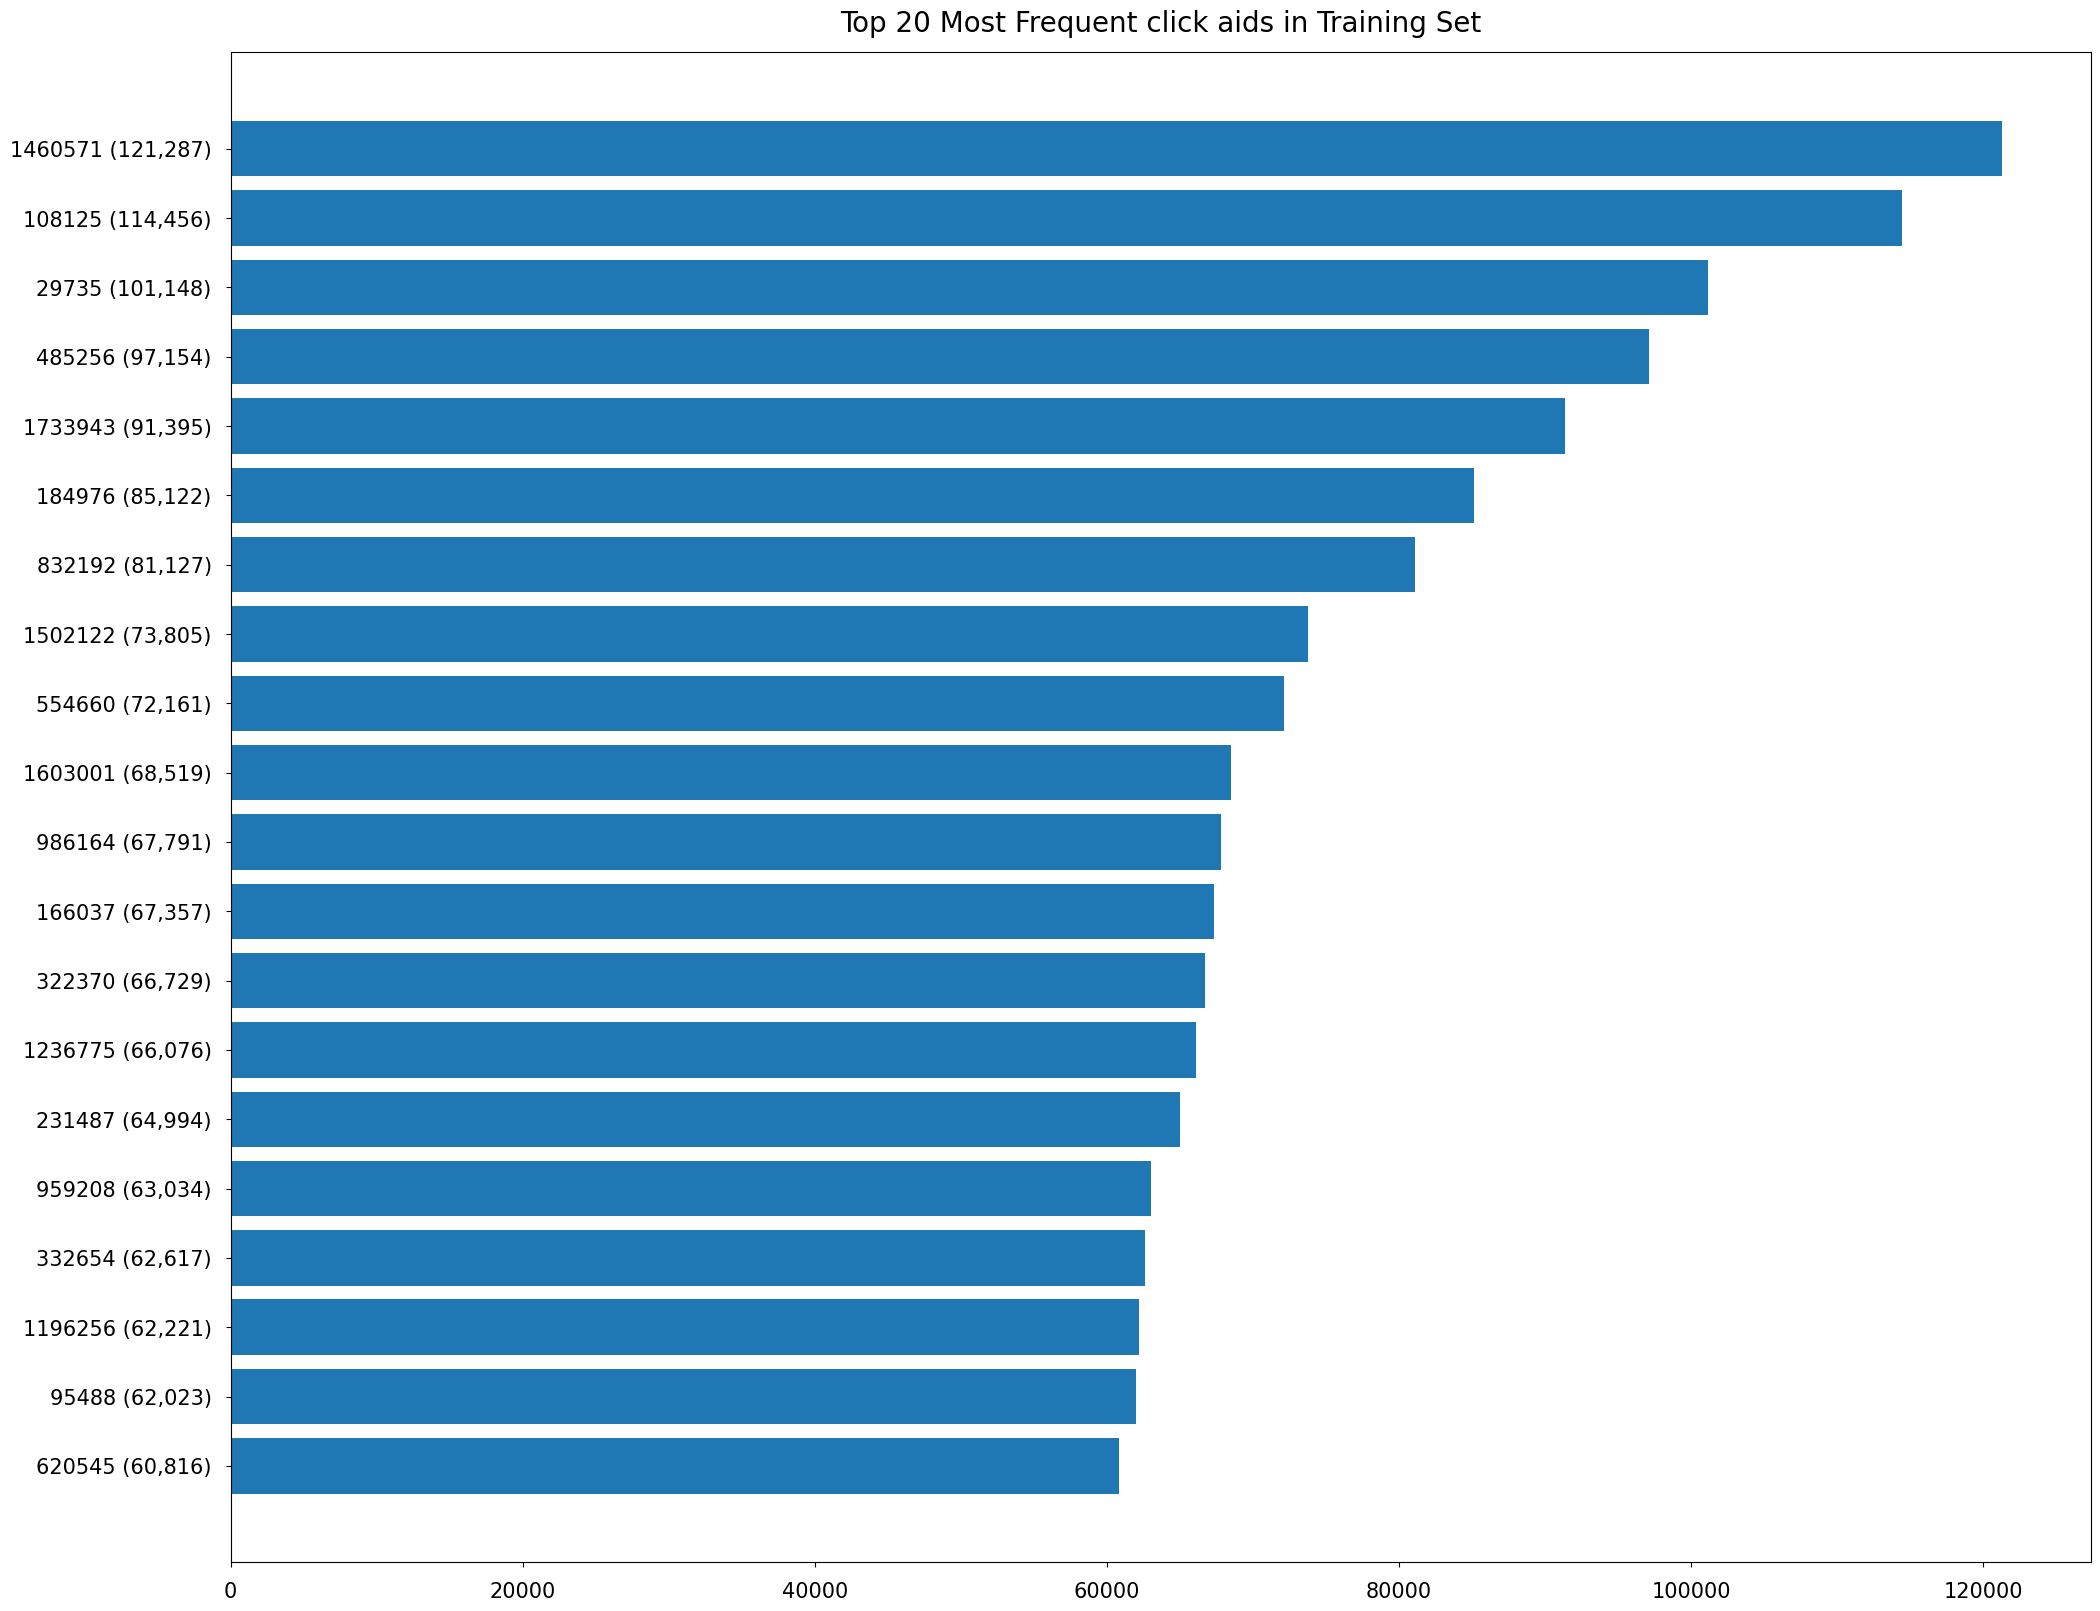

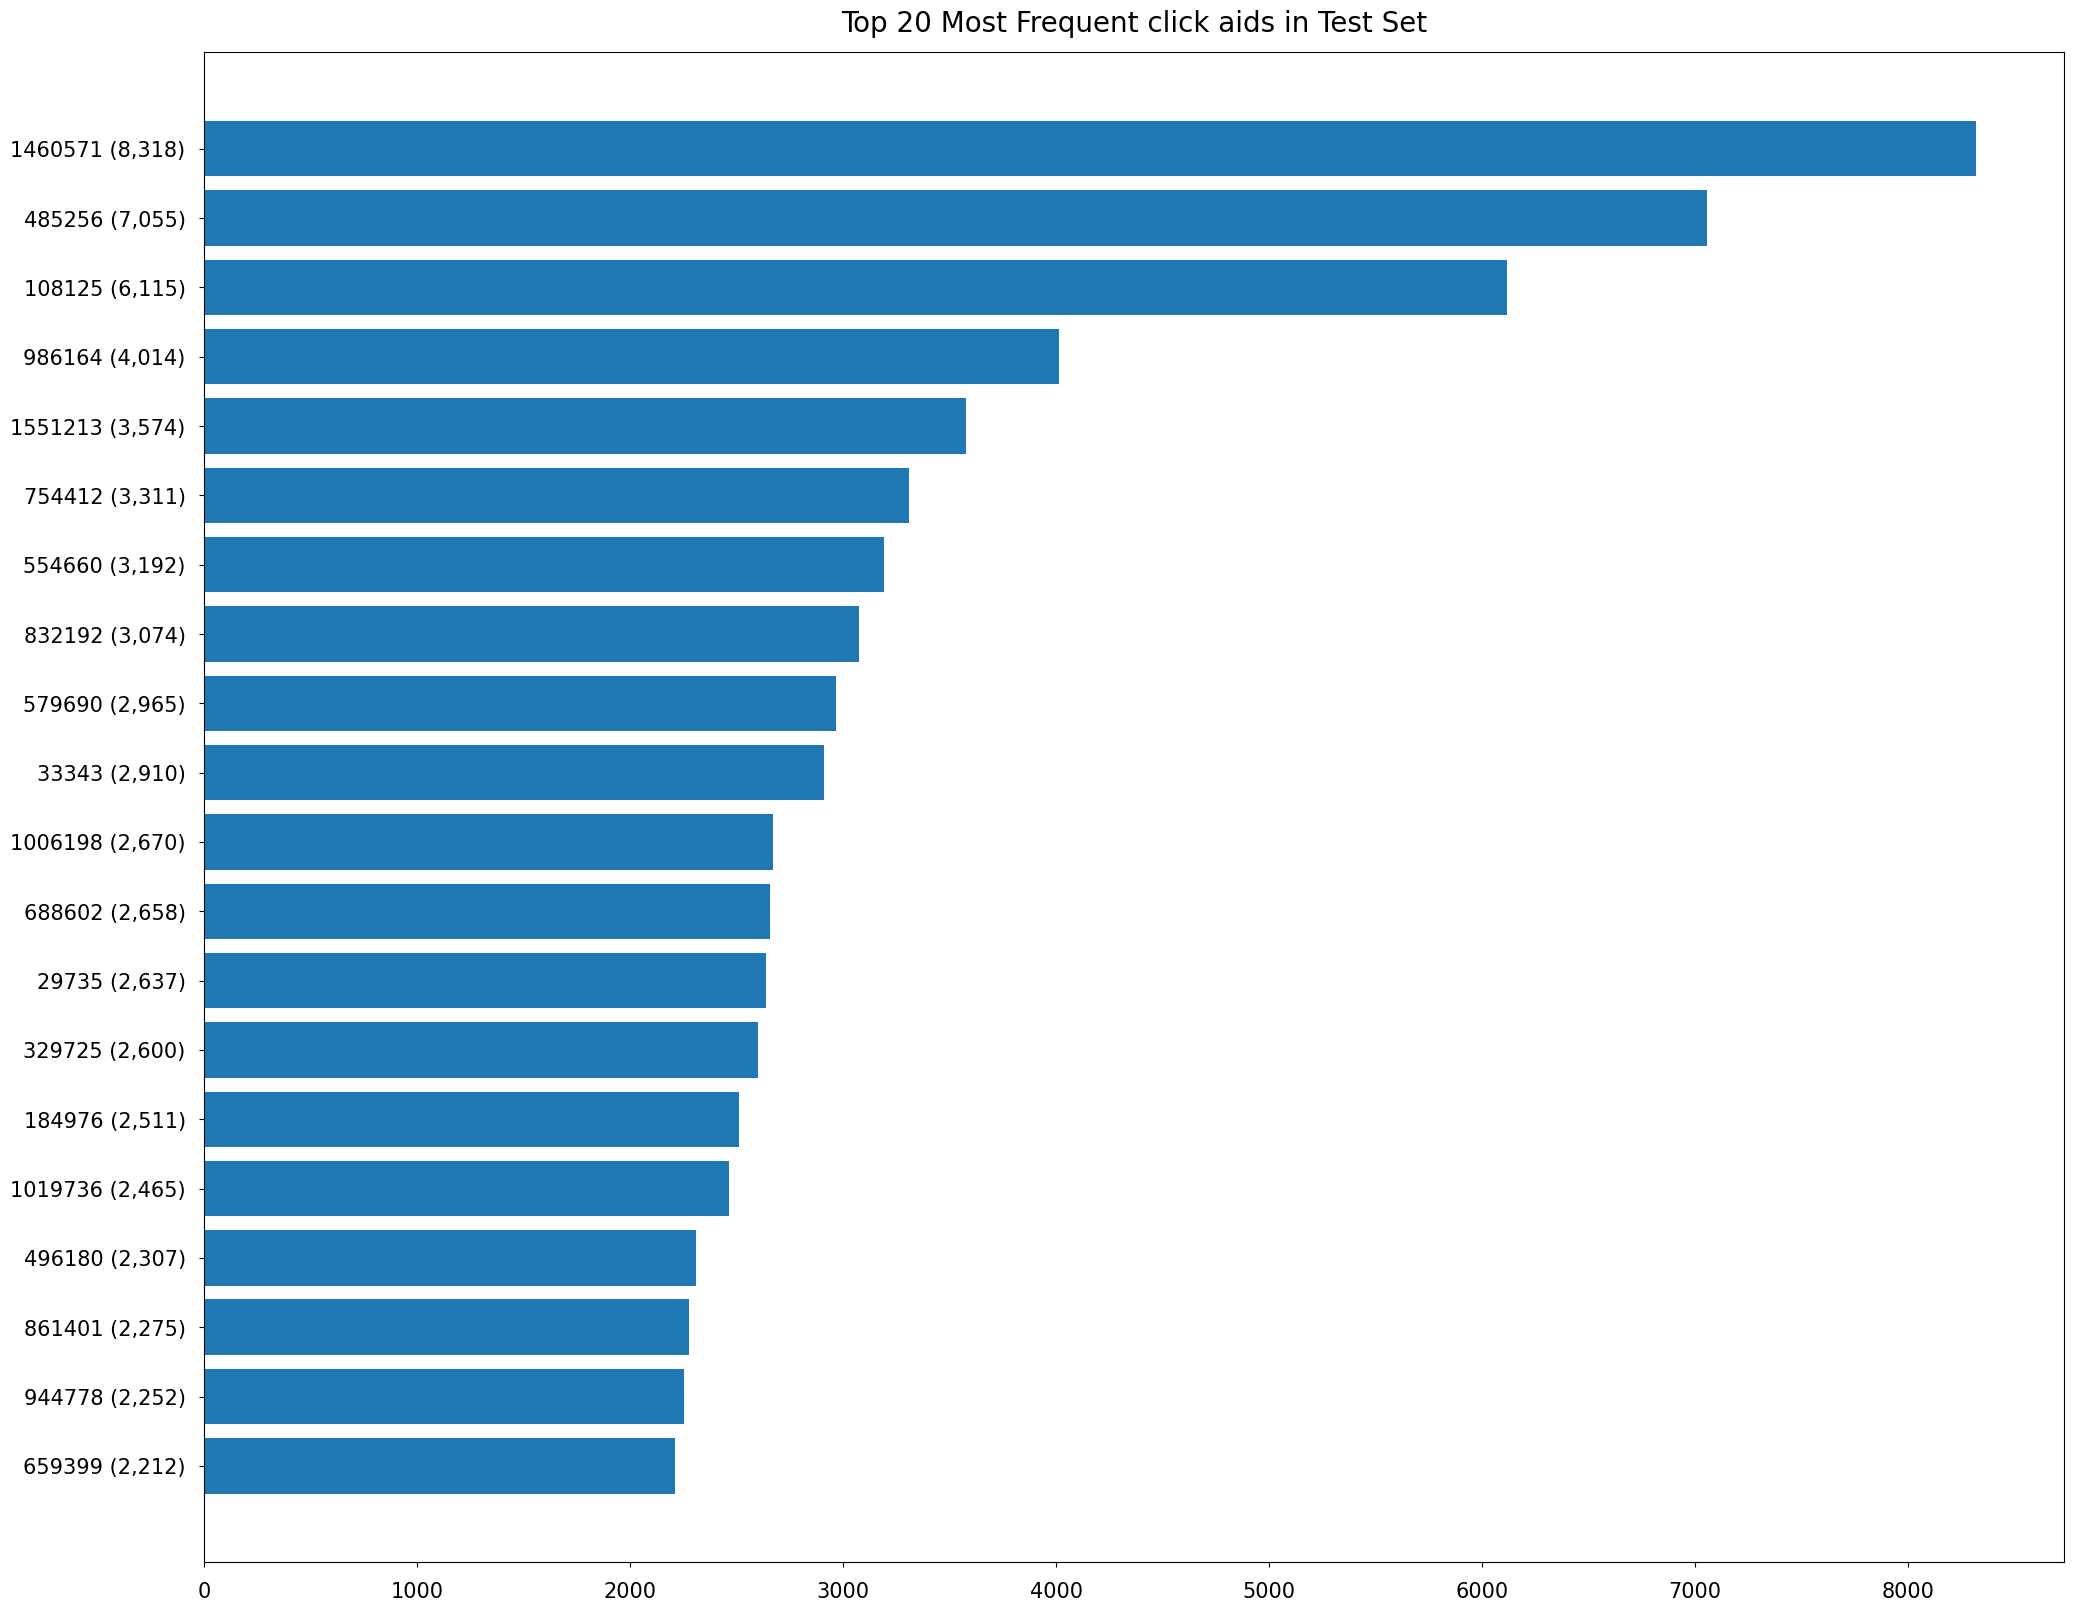

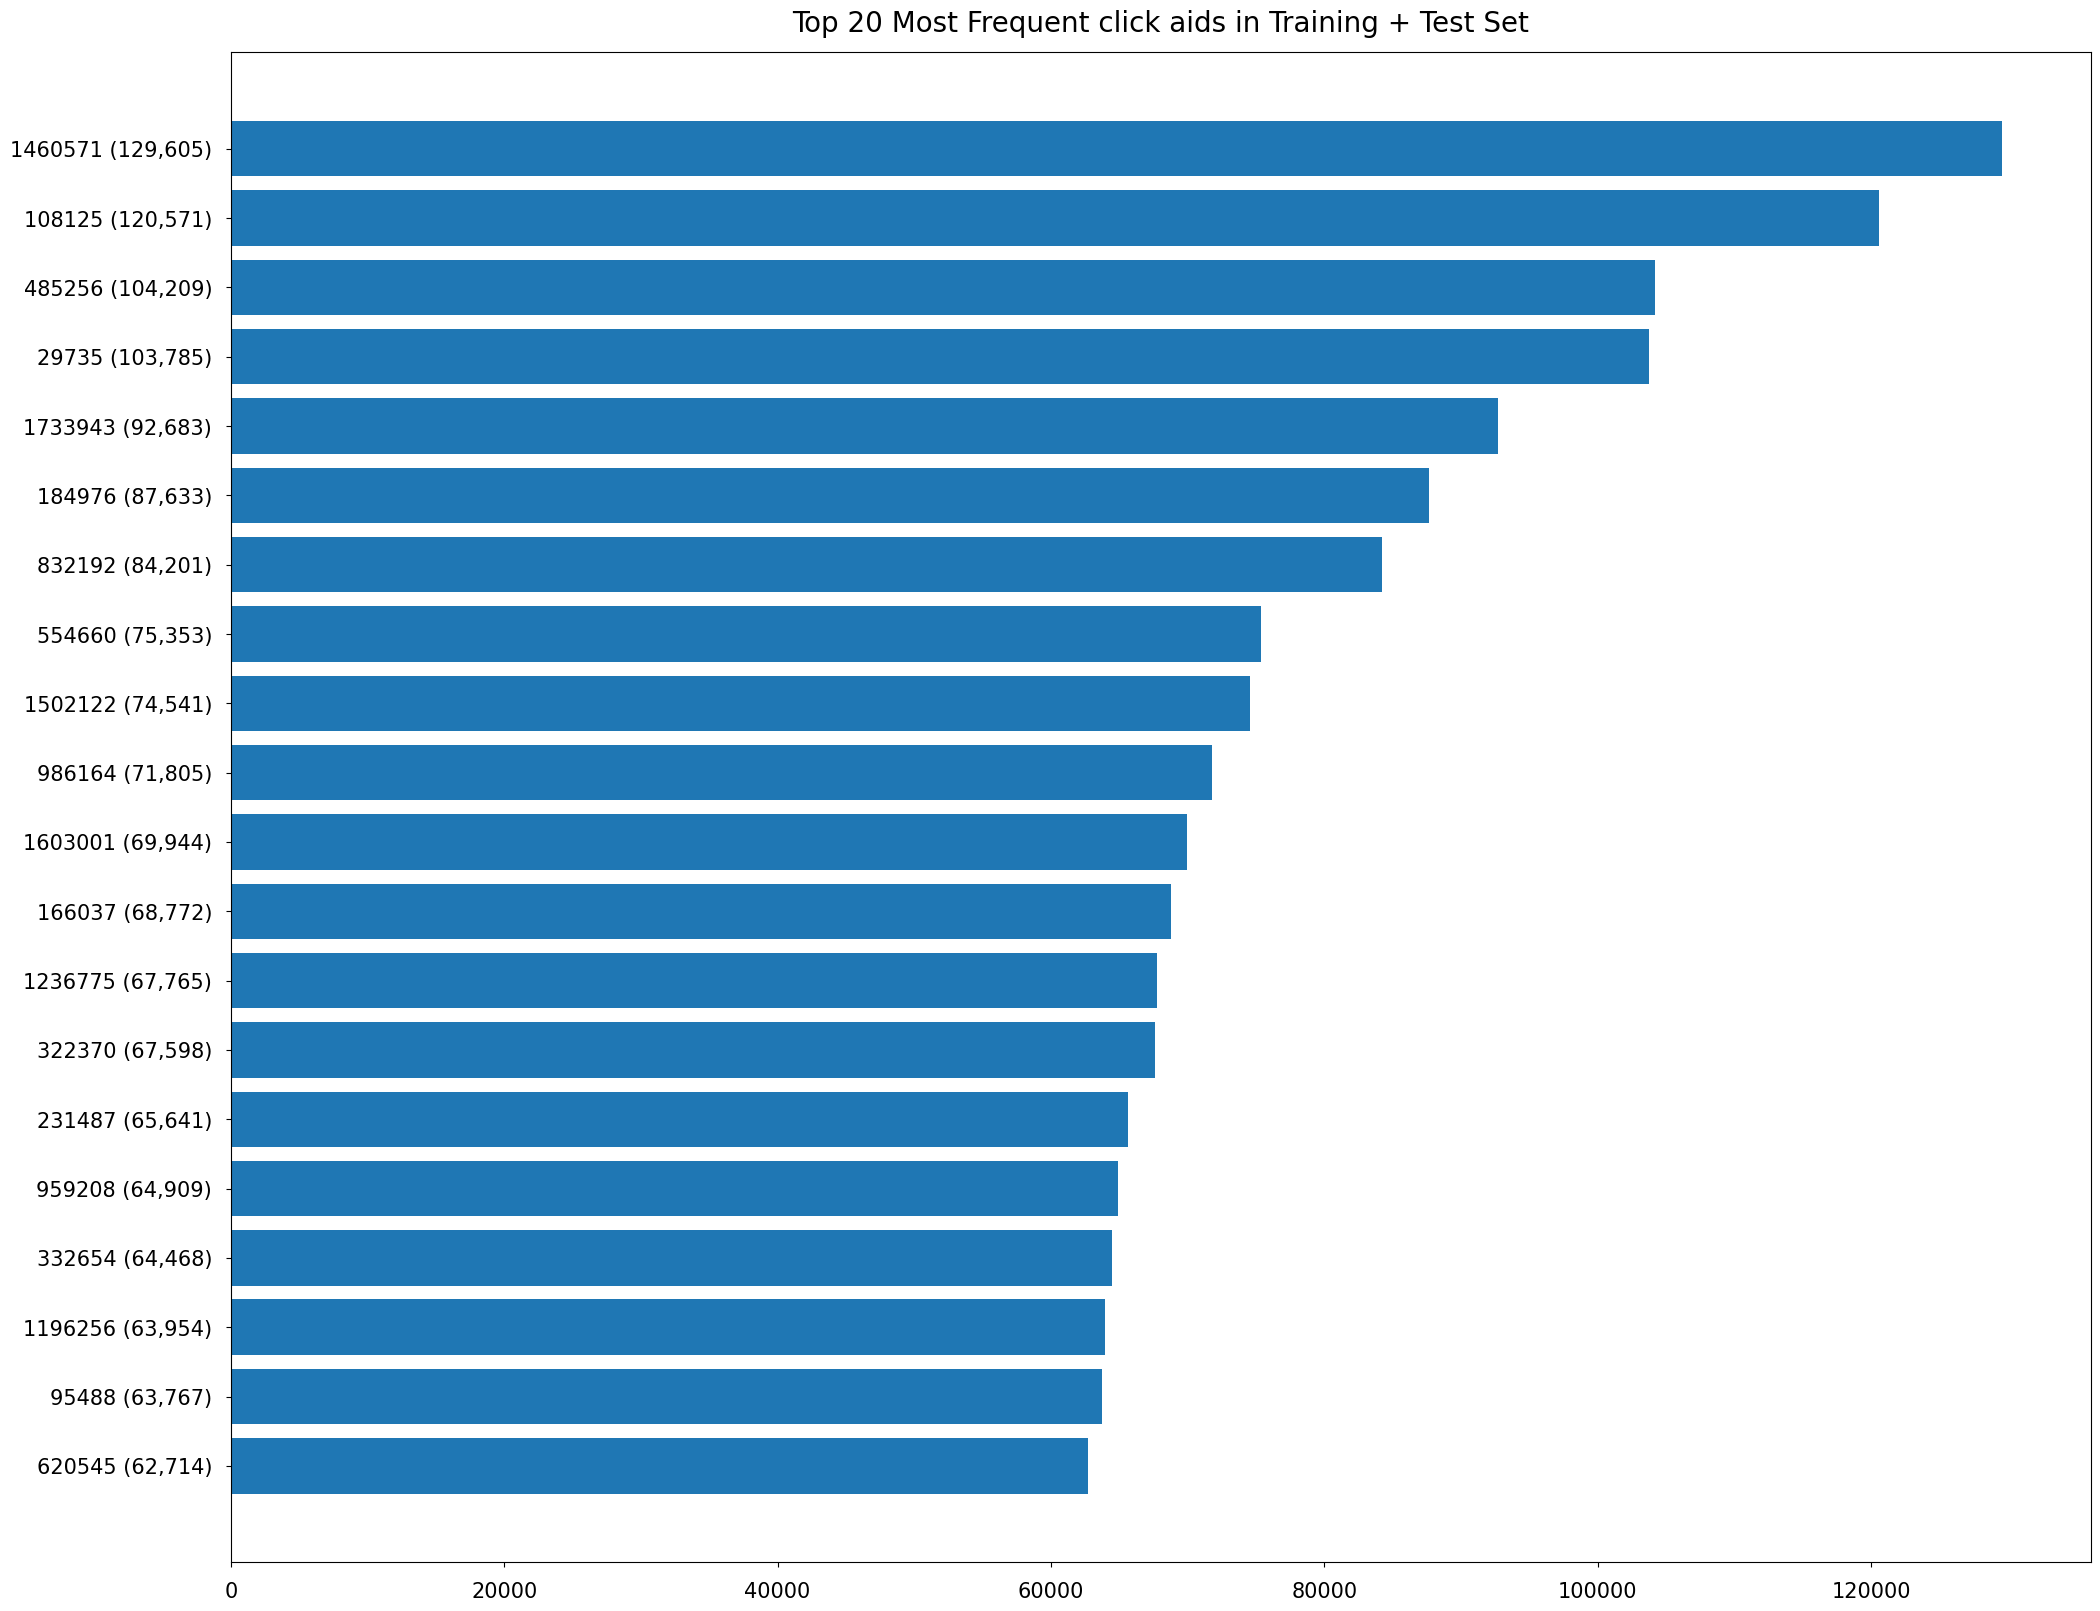

In [11]:
visualize_aid_frequencies(
    aid_frequencies=train_20_most_frequent_click_aids,
    title='Top 20 Most Frequent click aids in Training Set'
)
visualize_aid_frequencies(
    aid_frequencies=test_20_most_frequent_click_aids,
    title='Top 20 Most Frequent click aids in Test Set'
)
visualize_aid_frequencies(
    aid_frequencies=all_20_most_frequent_click_aids,
    title='Top 20 Most Frequent click aids in Training + Test Set'
)

Top 20 most frequent cart aids are visualized for training, test and training + test sets below. X axis is the frequency and y axis labels are aid and its frequency inside parentheses.

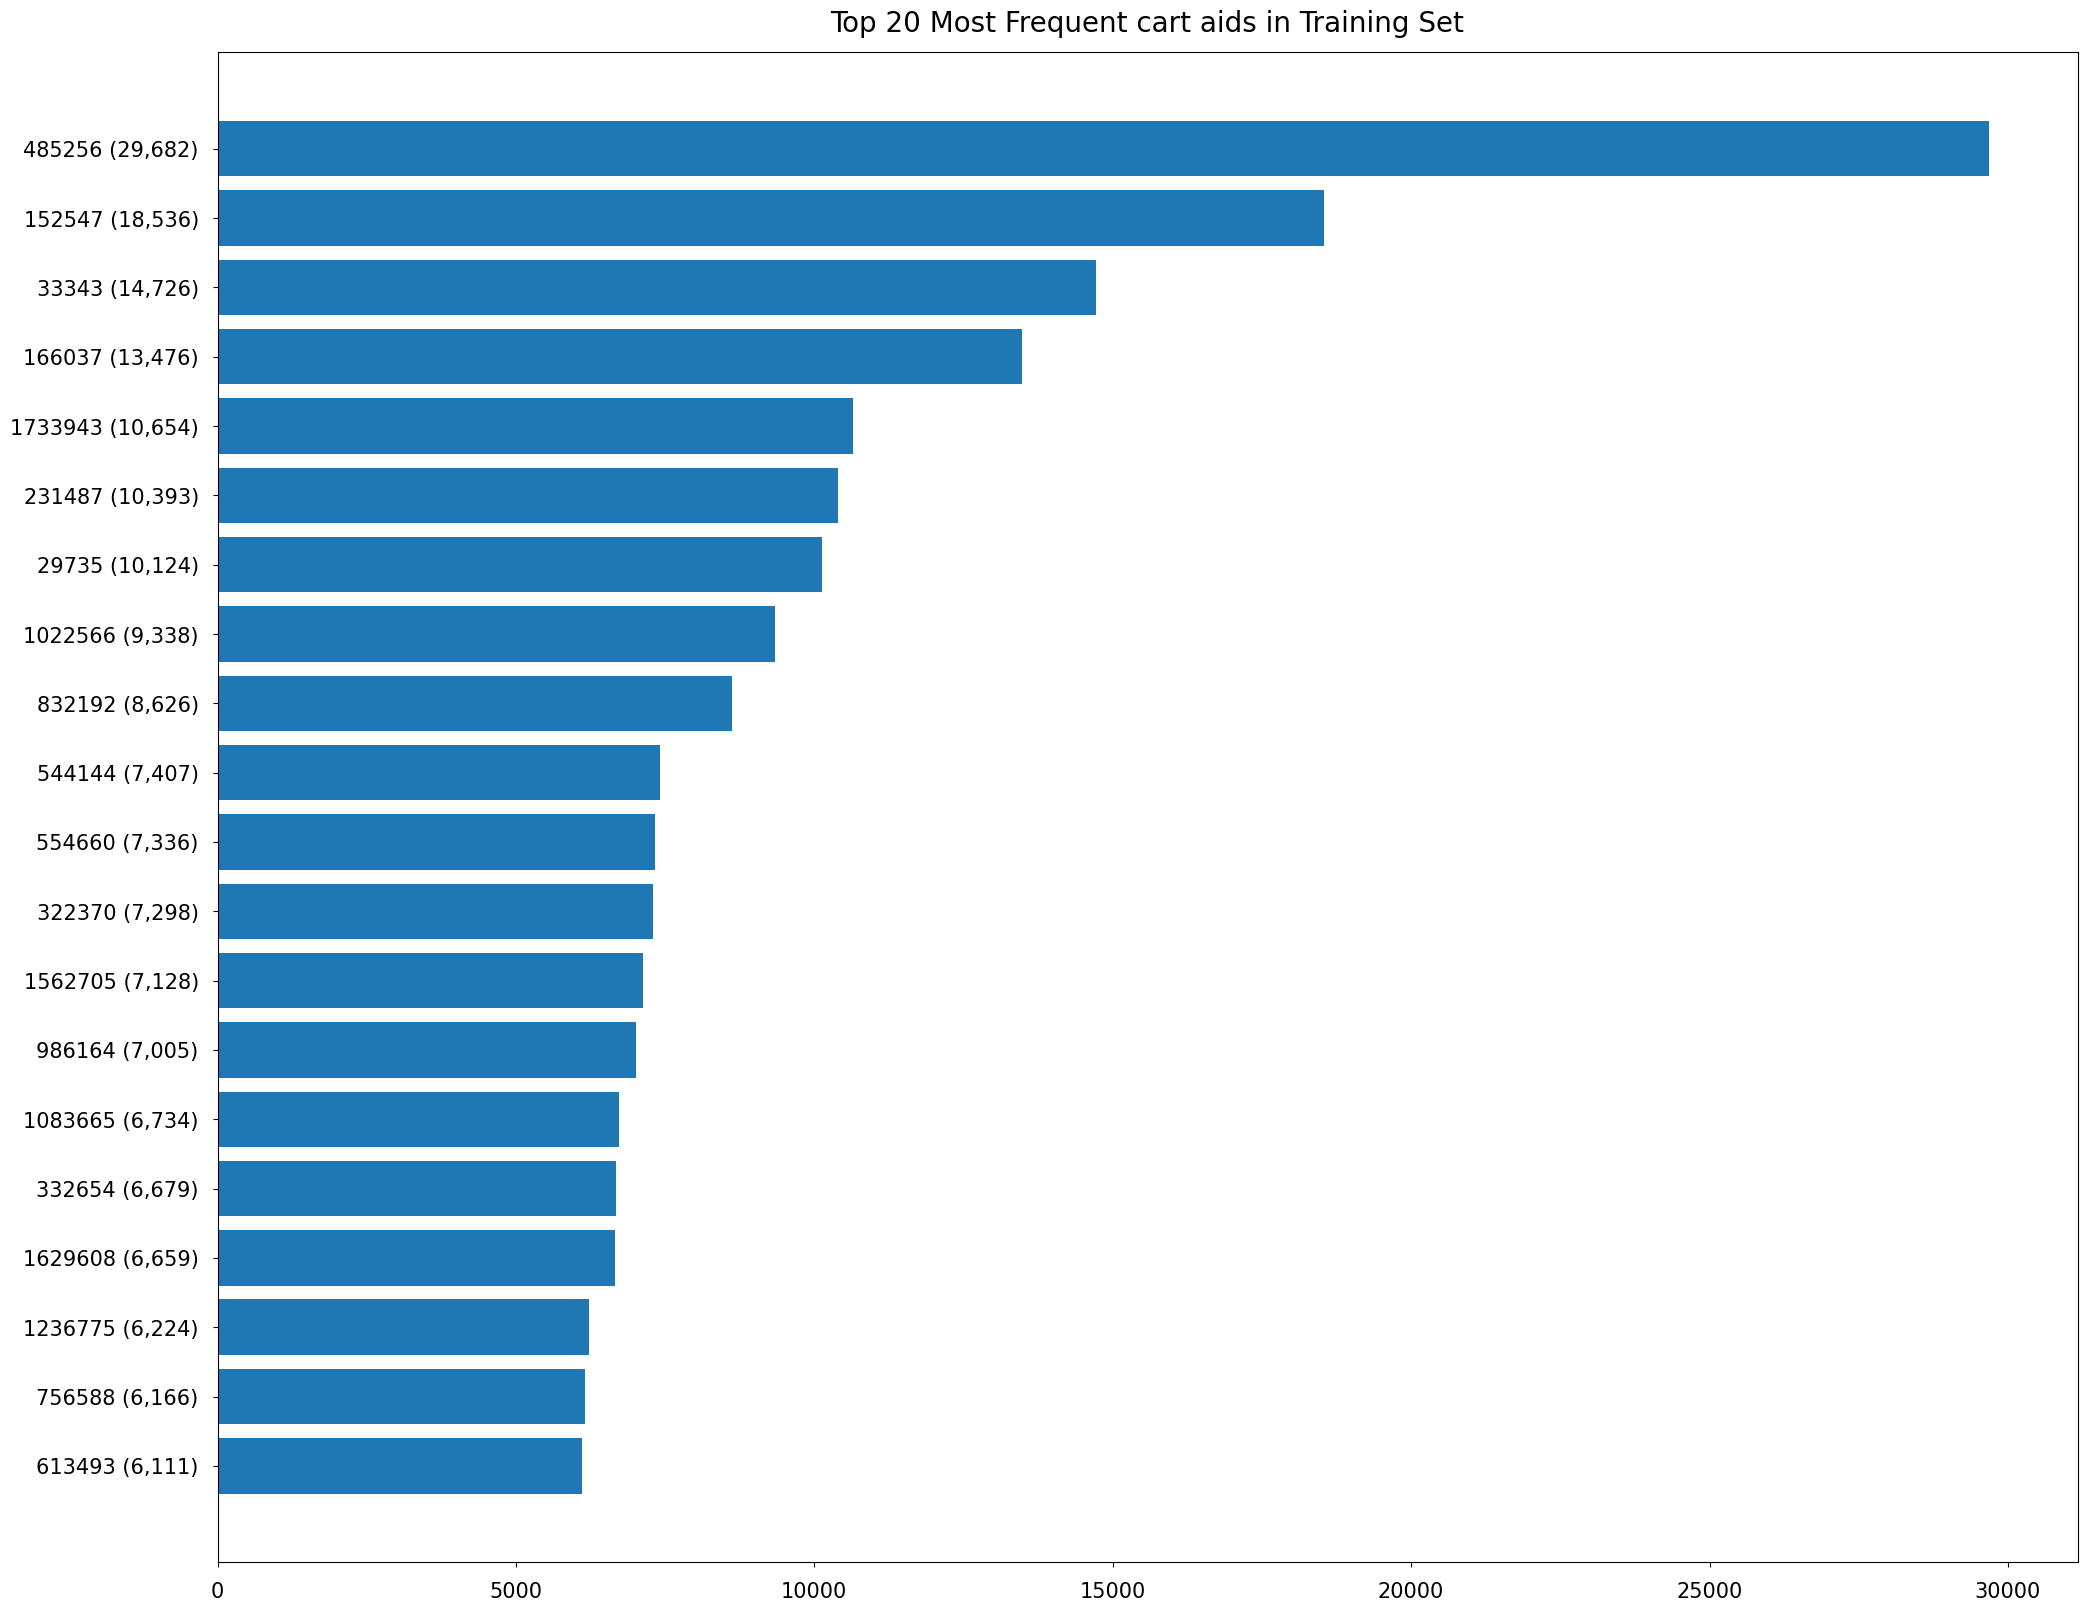

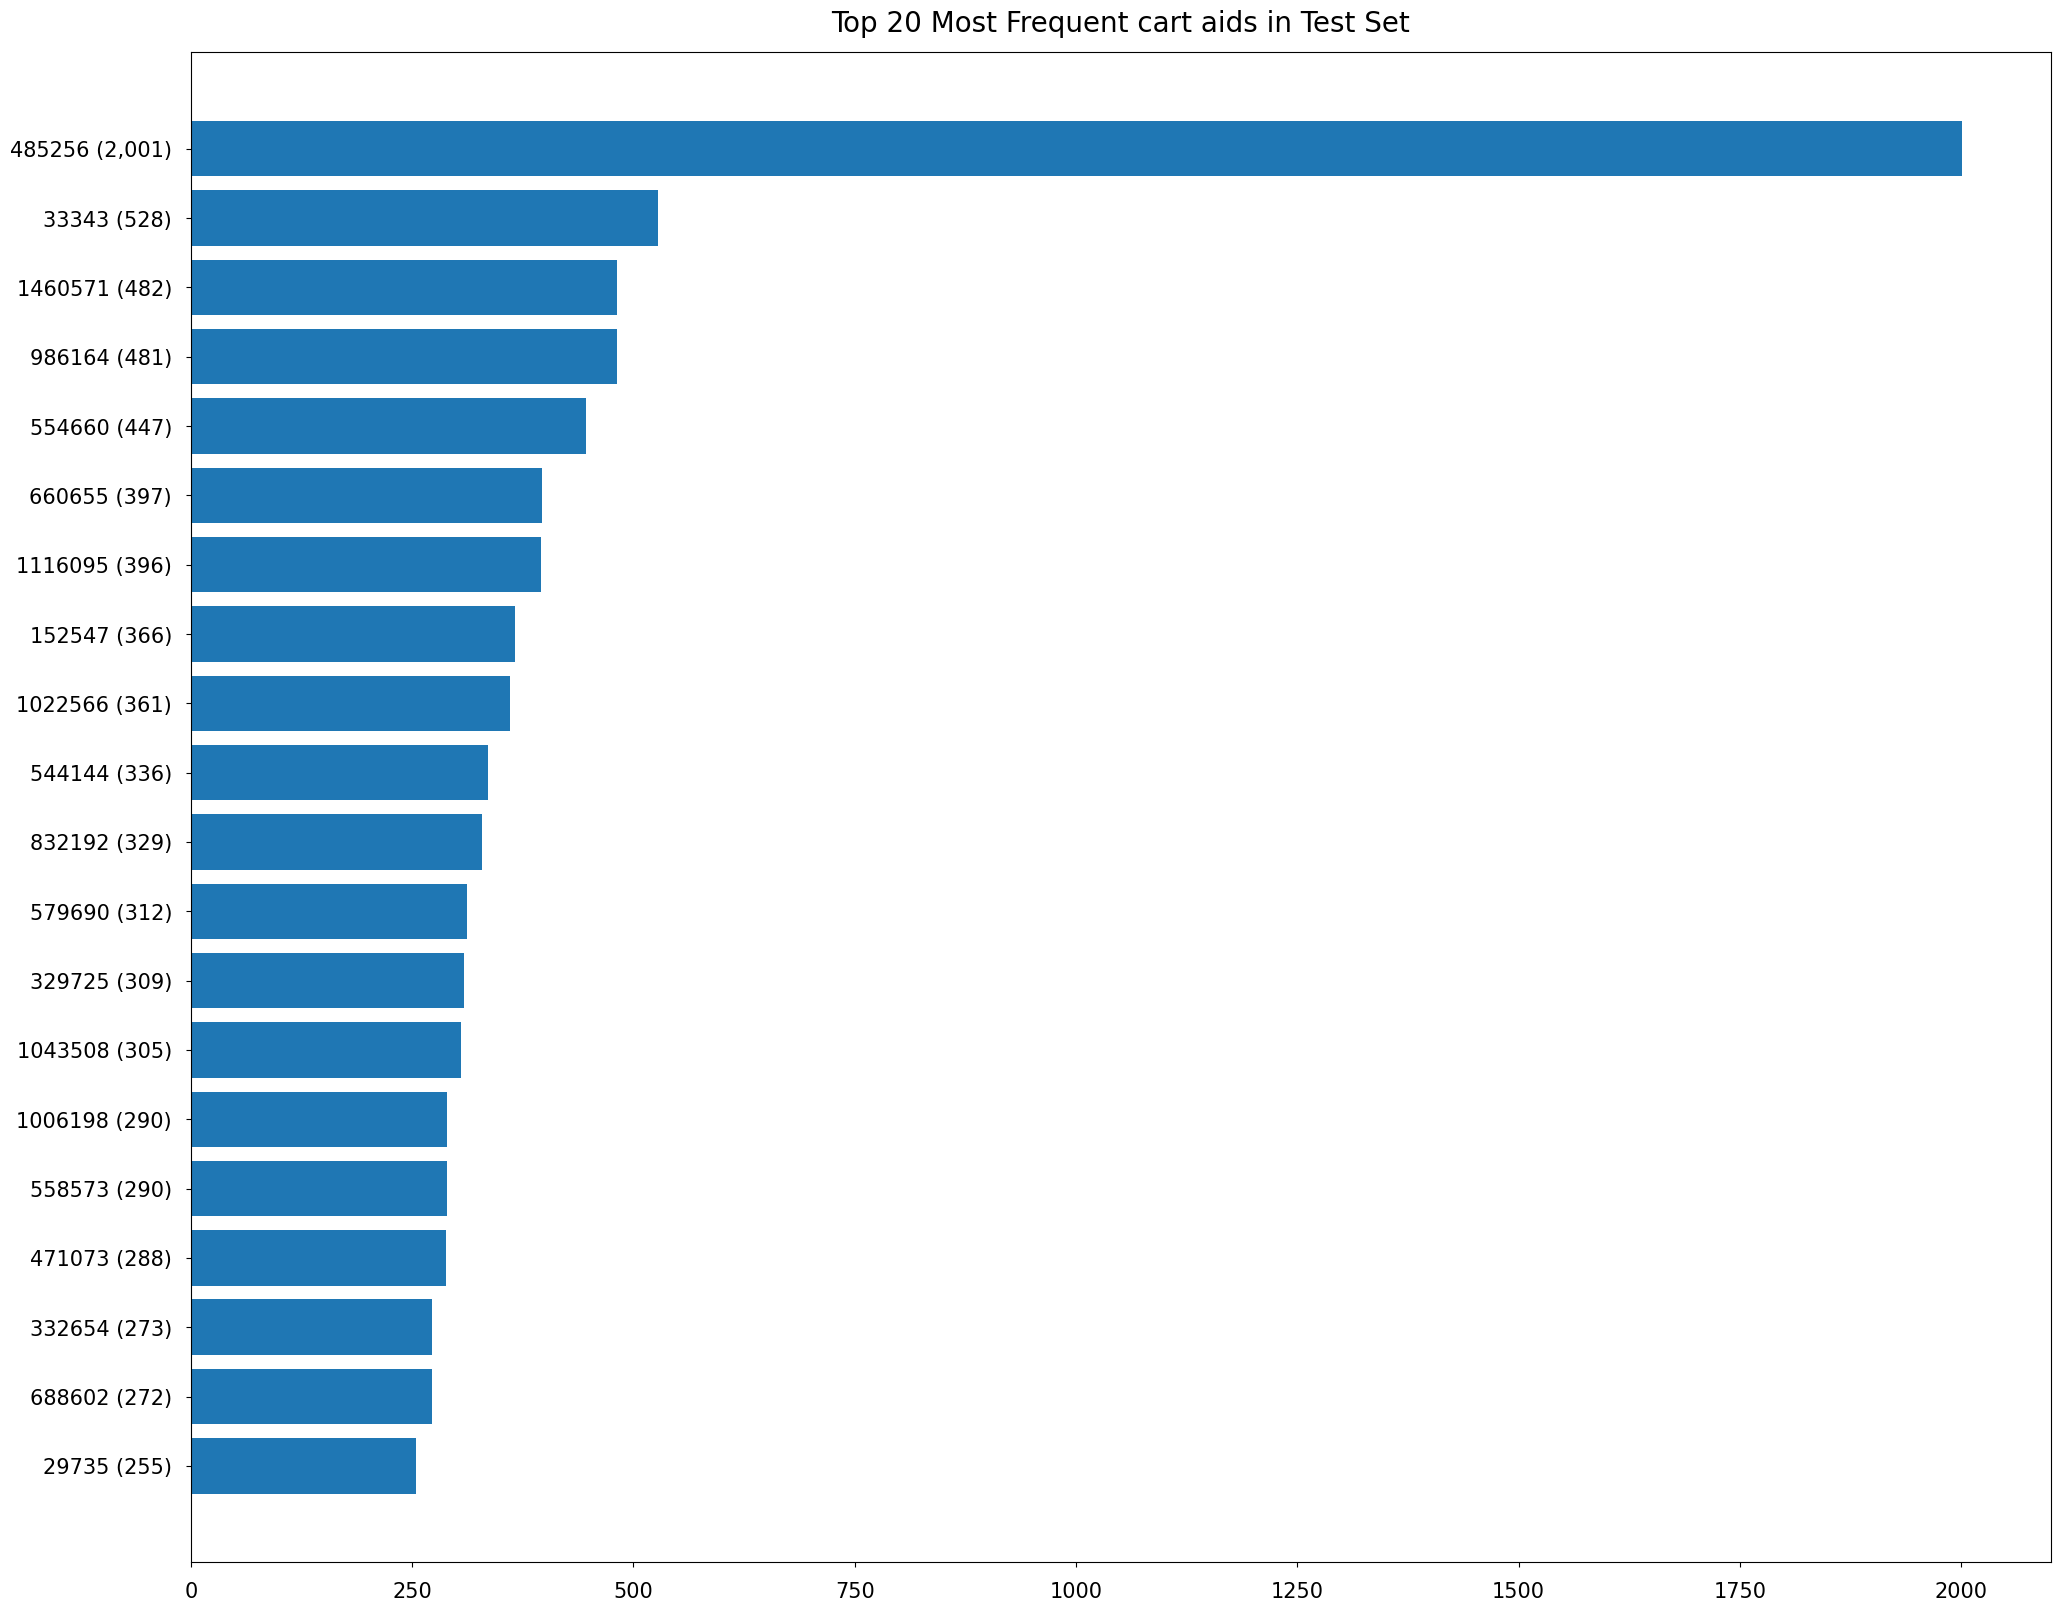

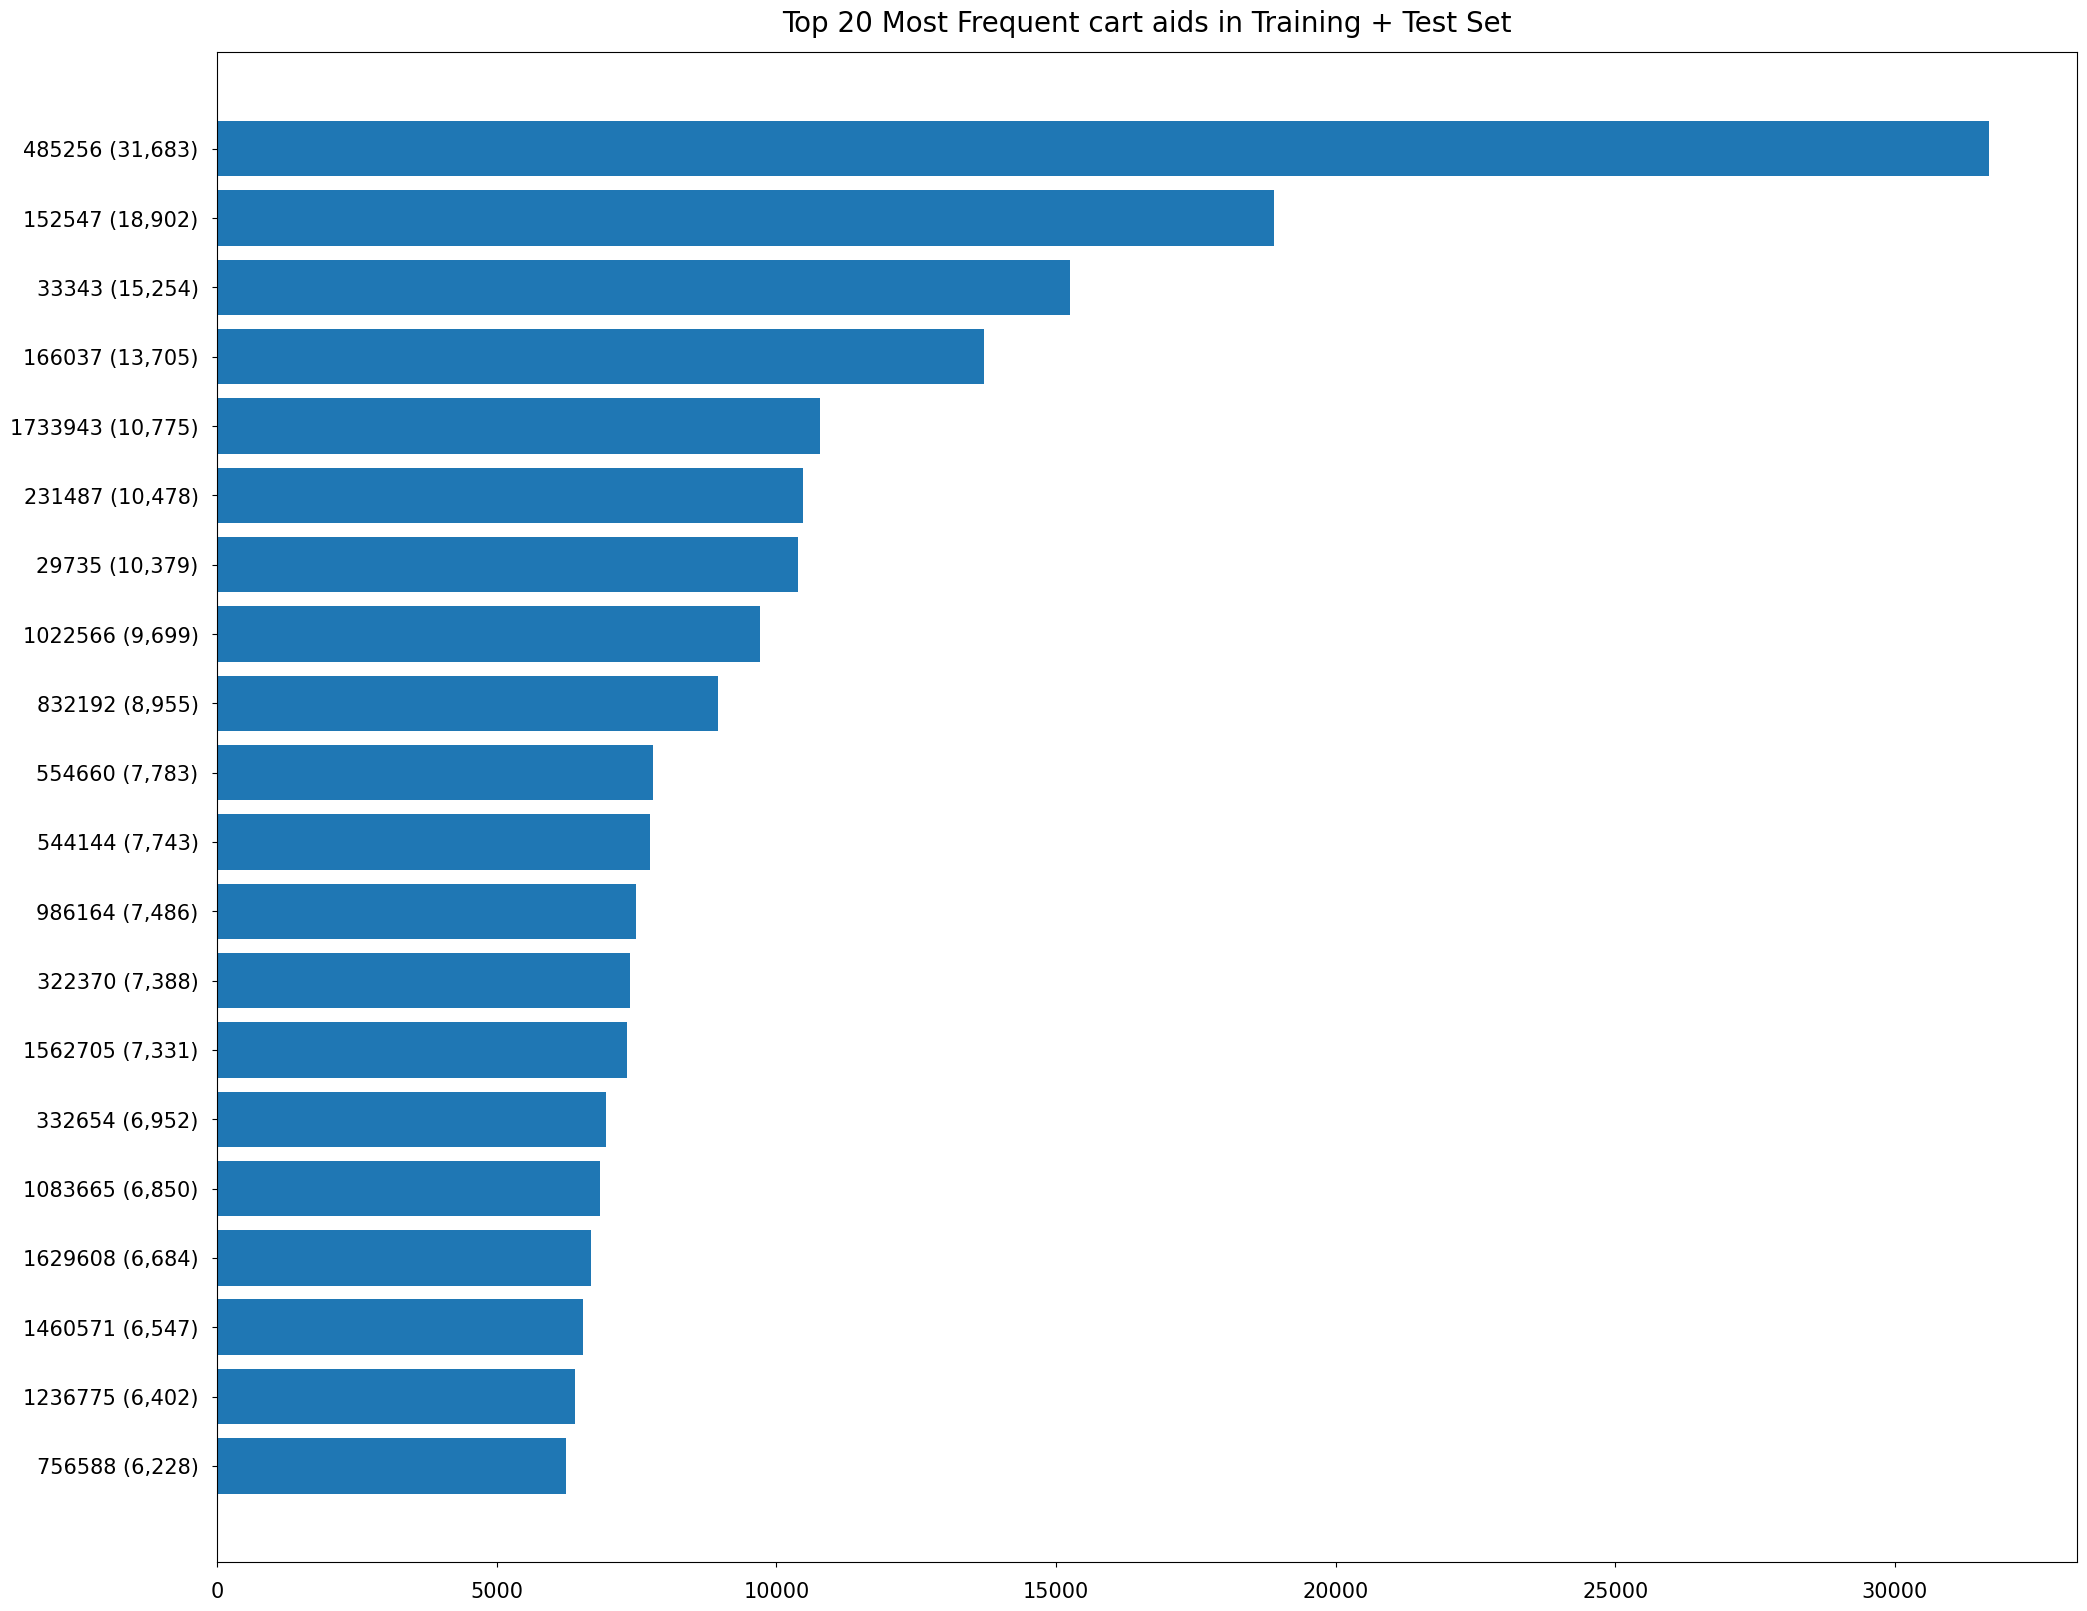

In [12]:
visualize_aid_frequencies(
    aid_frequencies=train_20_most_frequent_cart_aids,
    title='Top 20 Most Frequent cart aids in Training Set'
)
visualize_aid_frequencies(
    aid_frequencies=test_20_most_frequent_cart_aids,
    title='Top 20 Most Frequent cart aids in Test Set'
)
visualize_aid_frequencies(
    aid_frequencies=all_20_most_frequent_cart_aids,
    title='Top 20 Most Frequent cart aids in Training + Test Set'
)

Top 20 most frequent order aids are visualized for training, test and training + test sets below. X axis is the frequency and y axis labels are aid and its frequency inside parentheses.

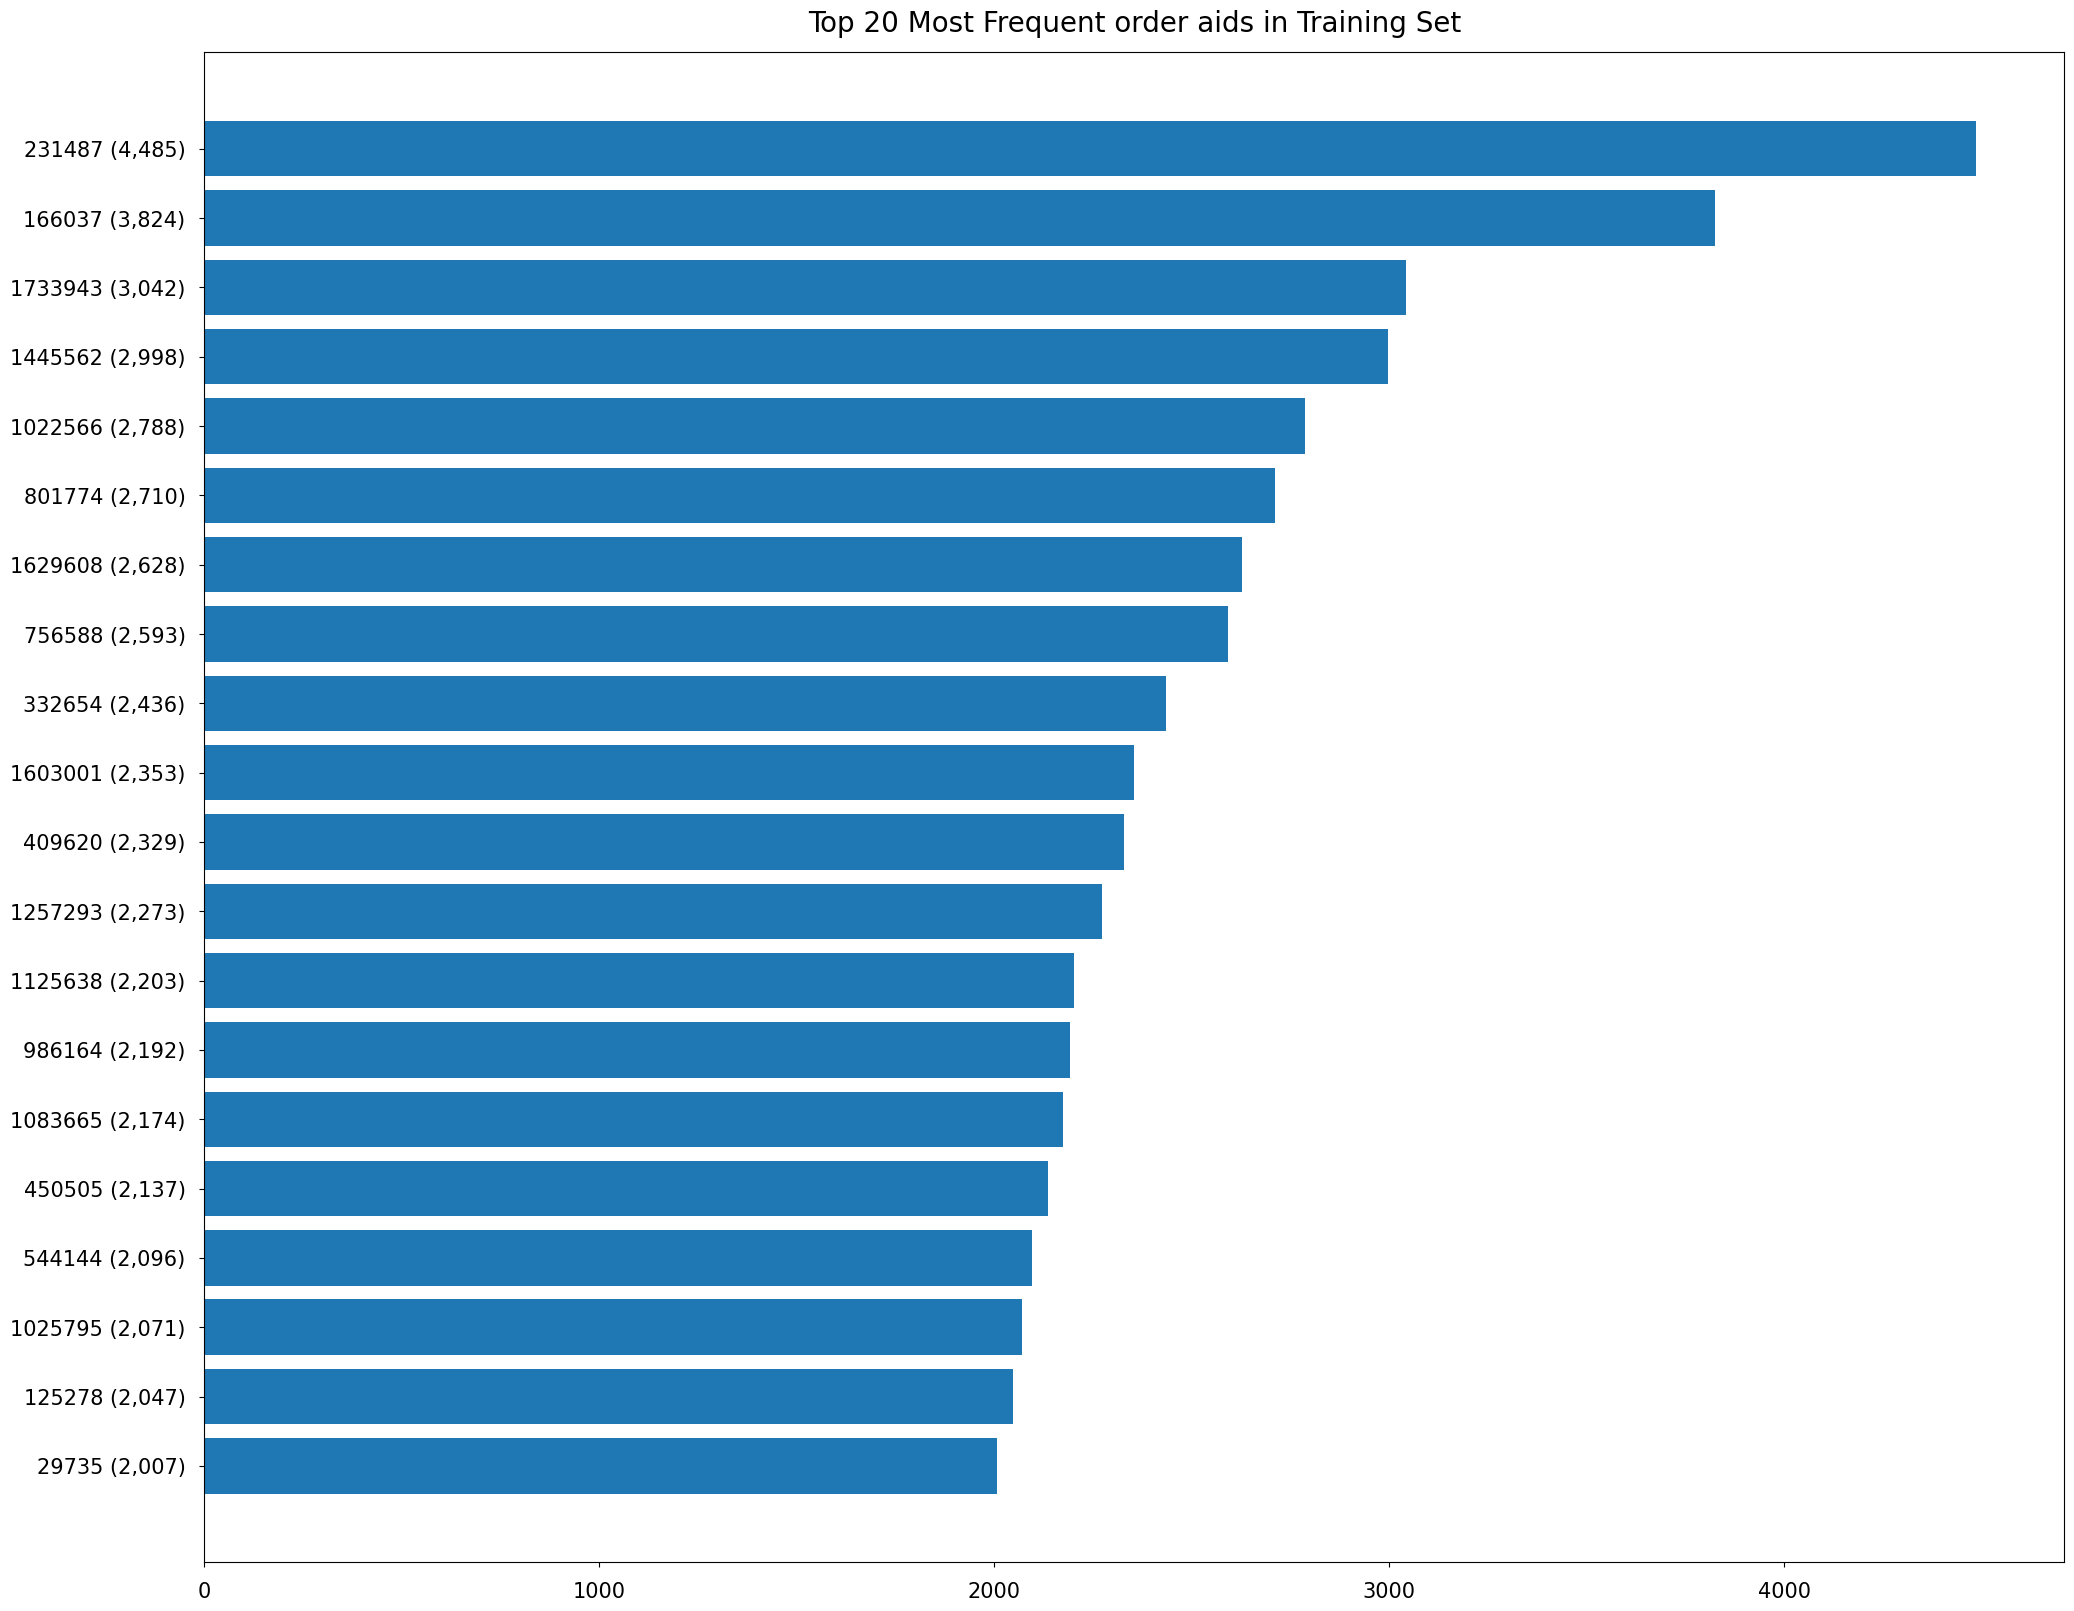

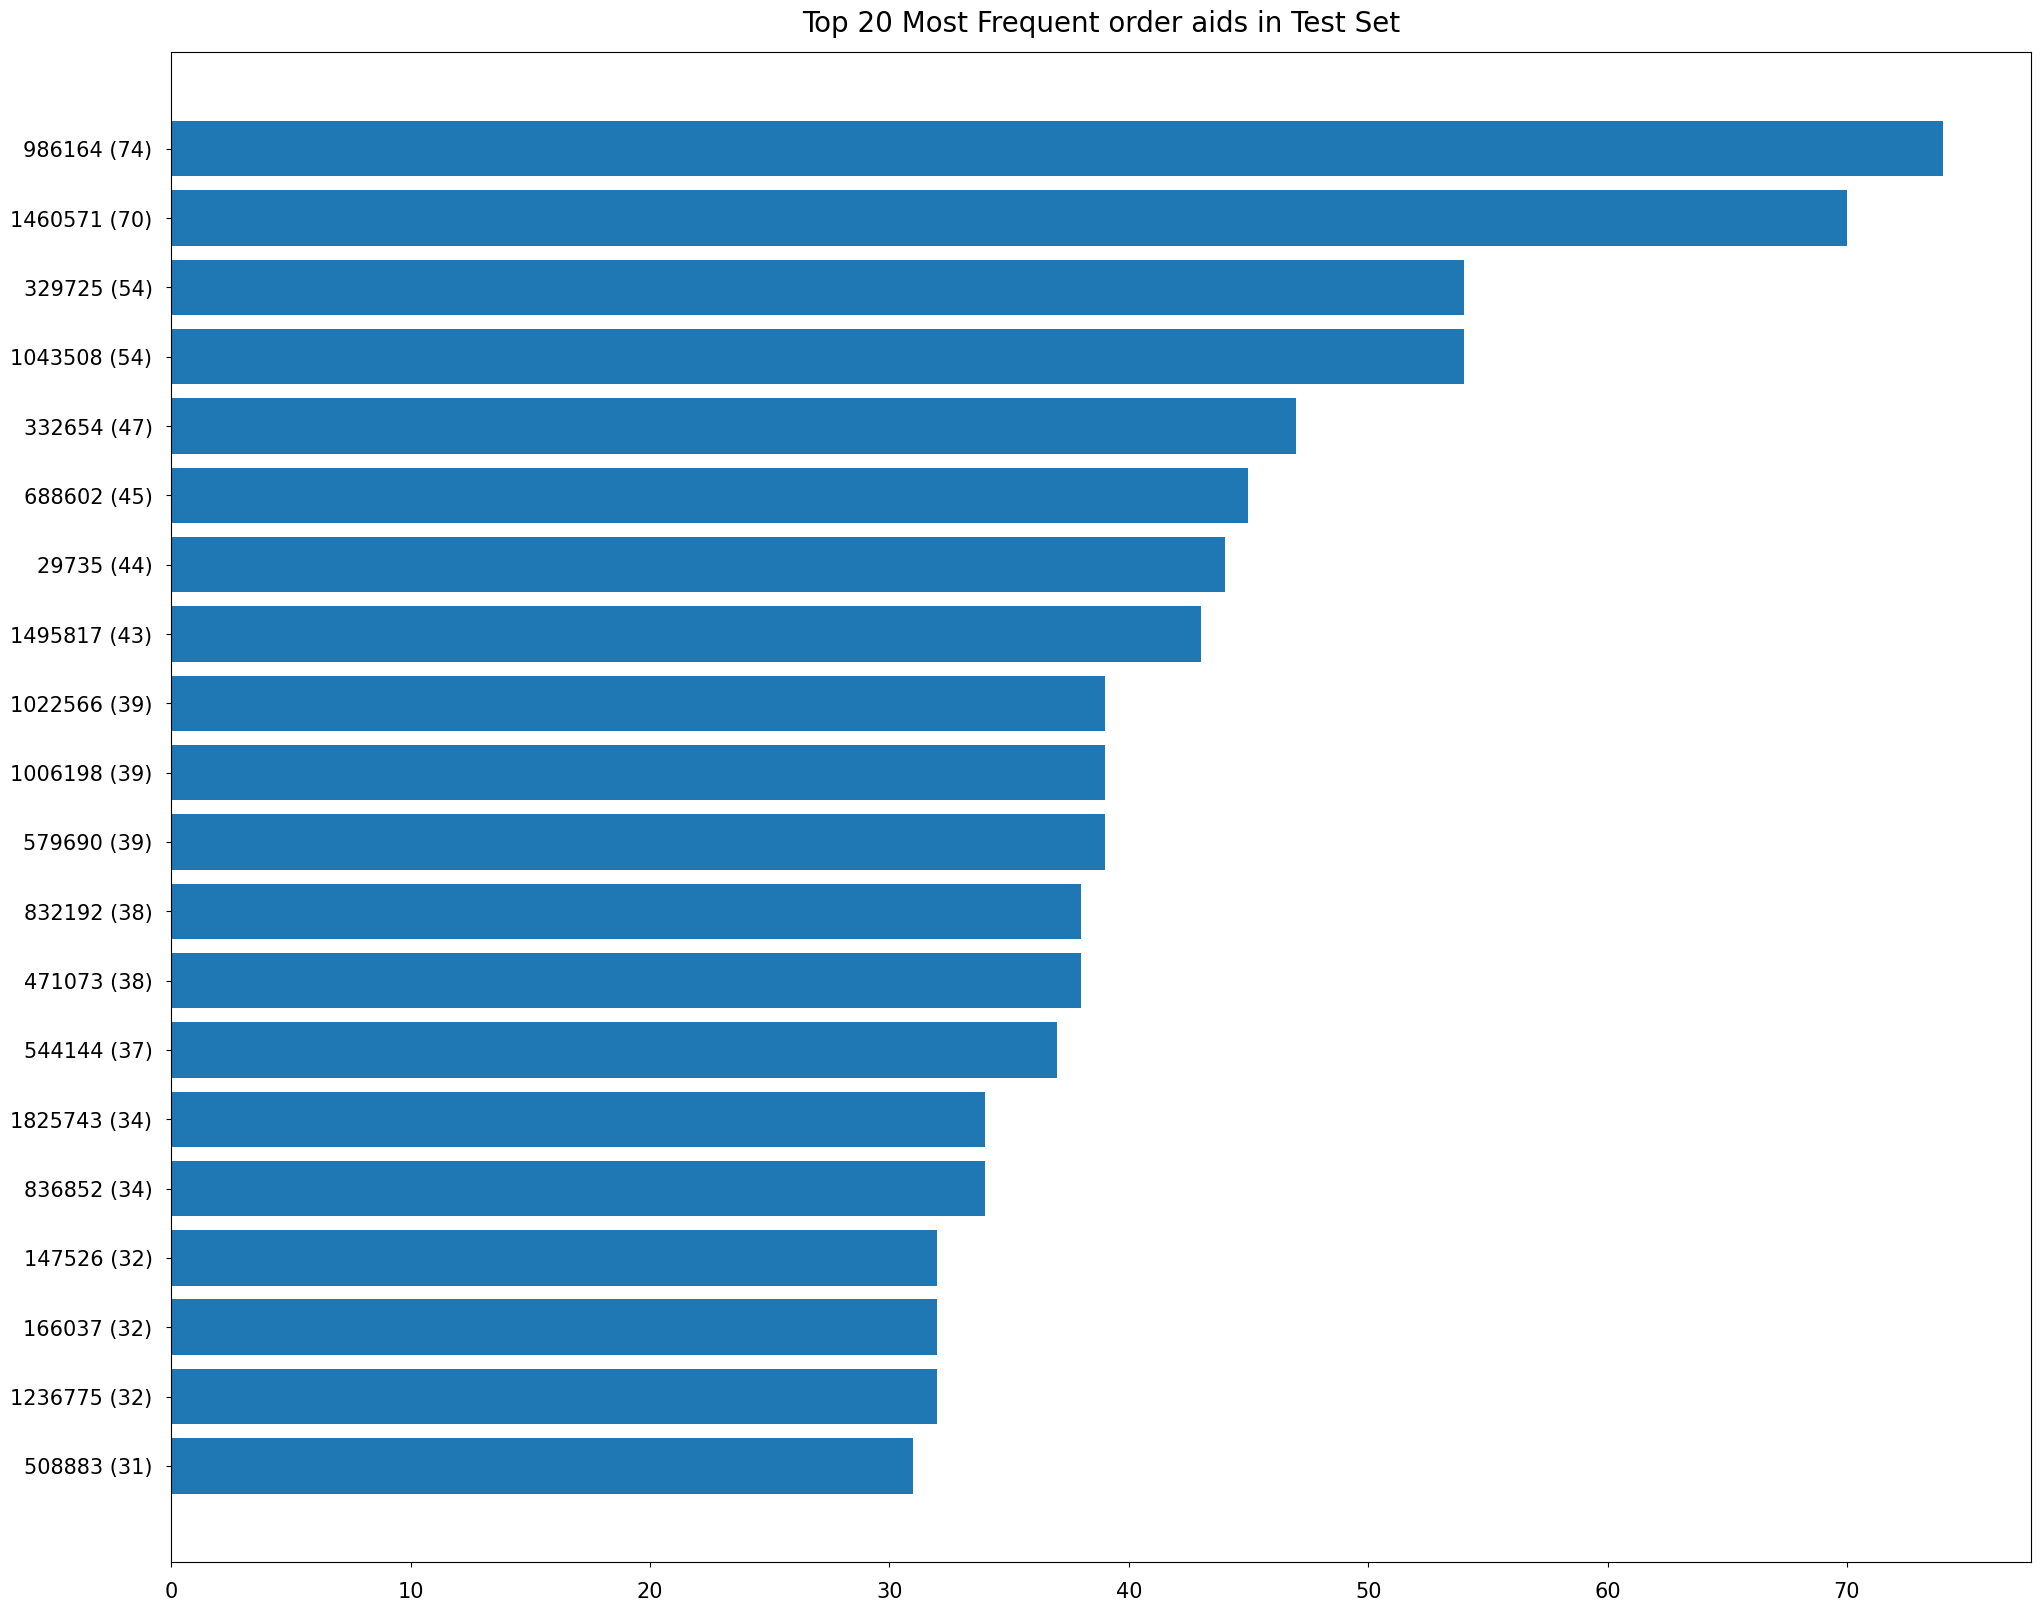

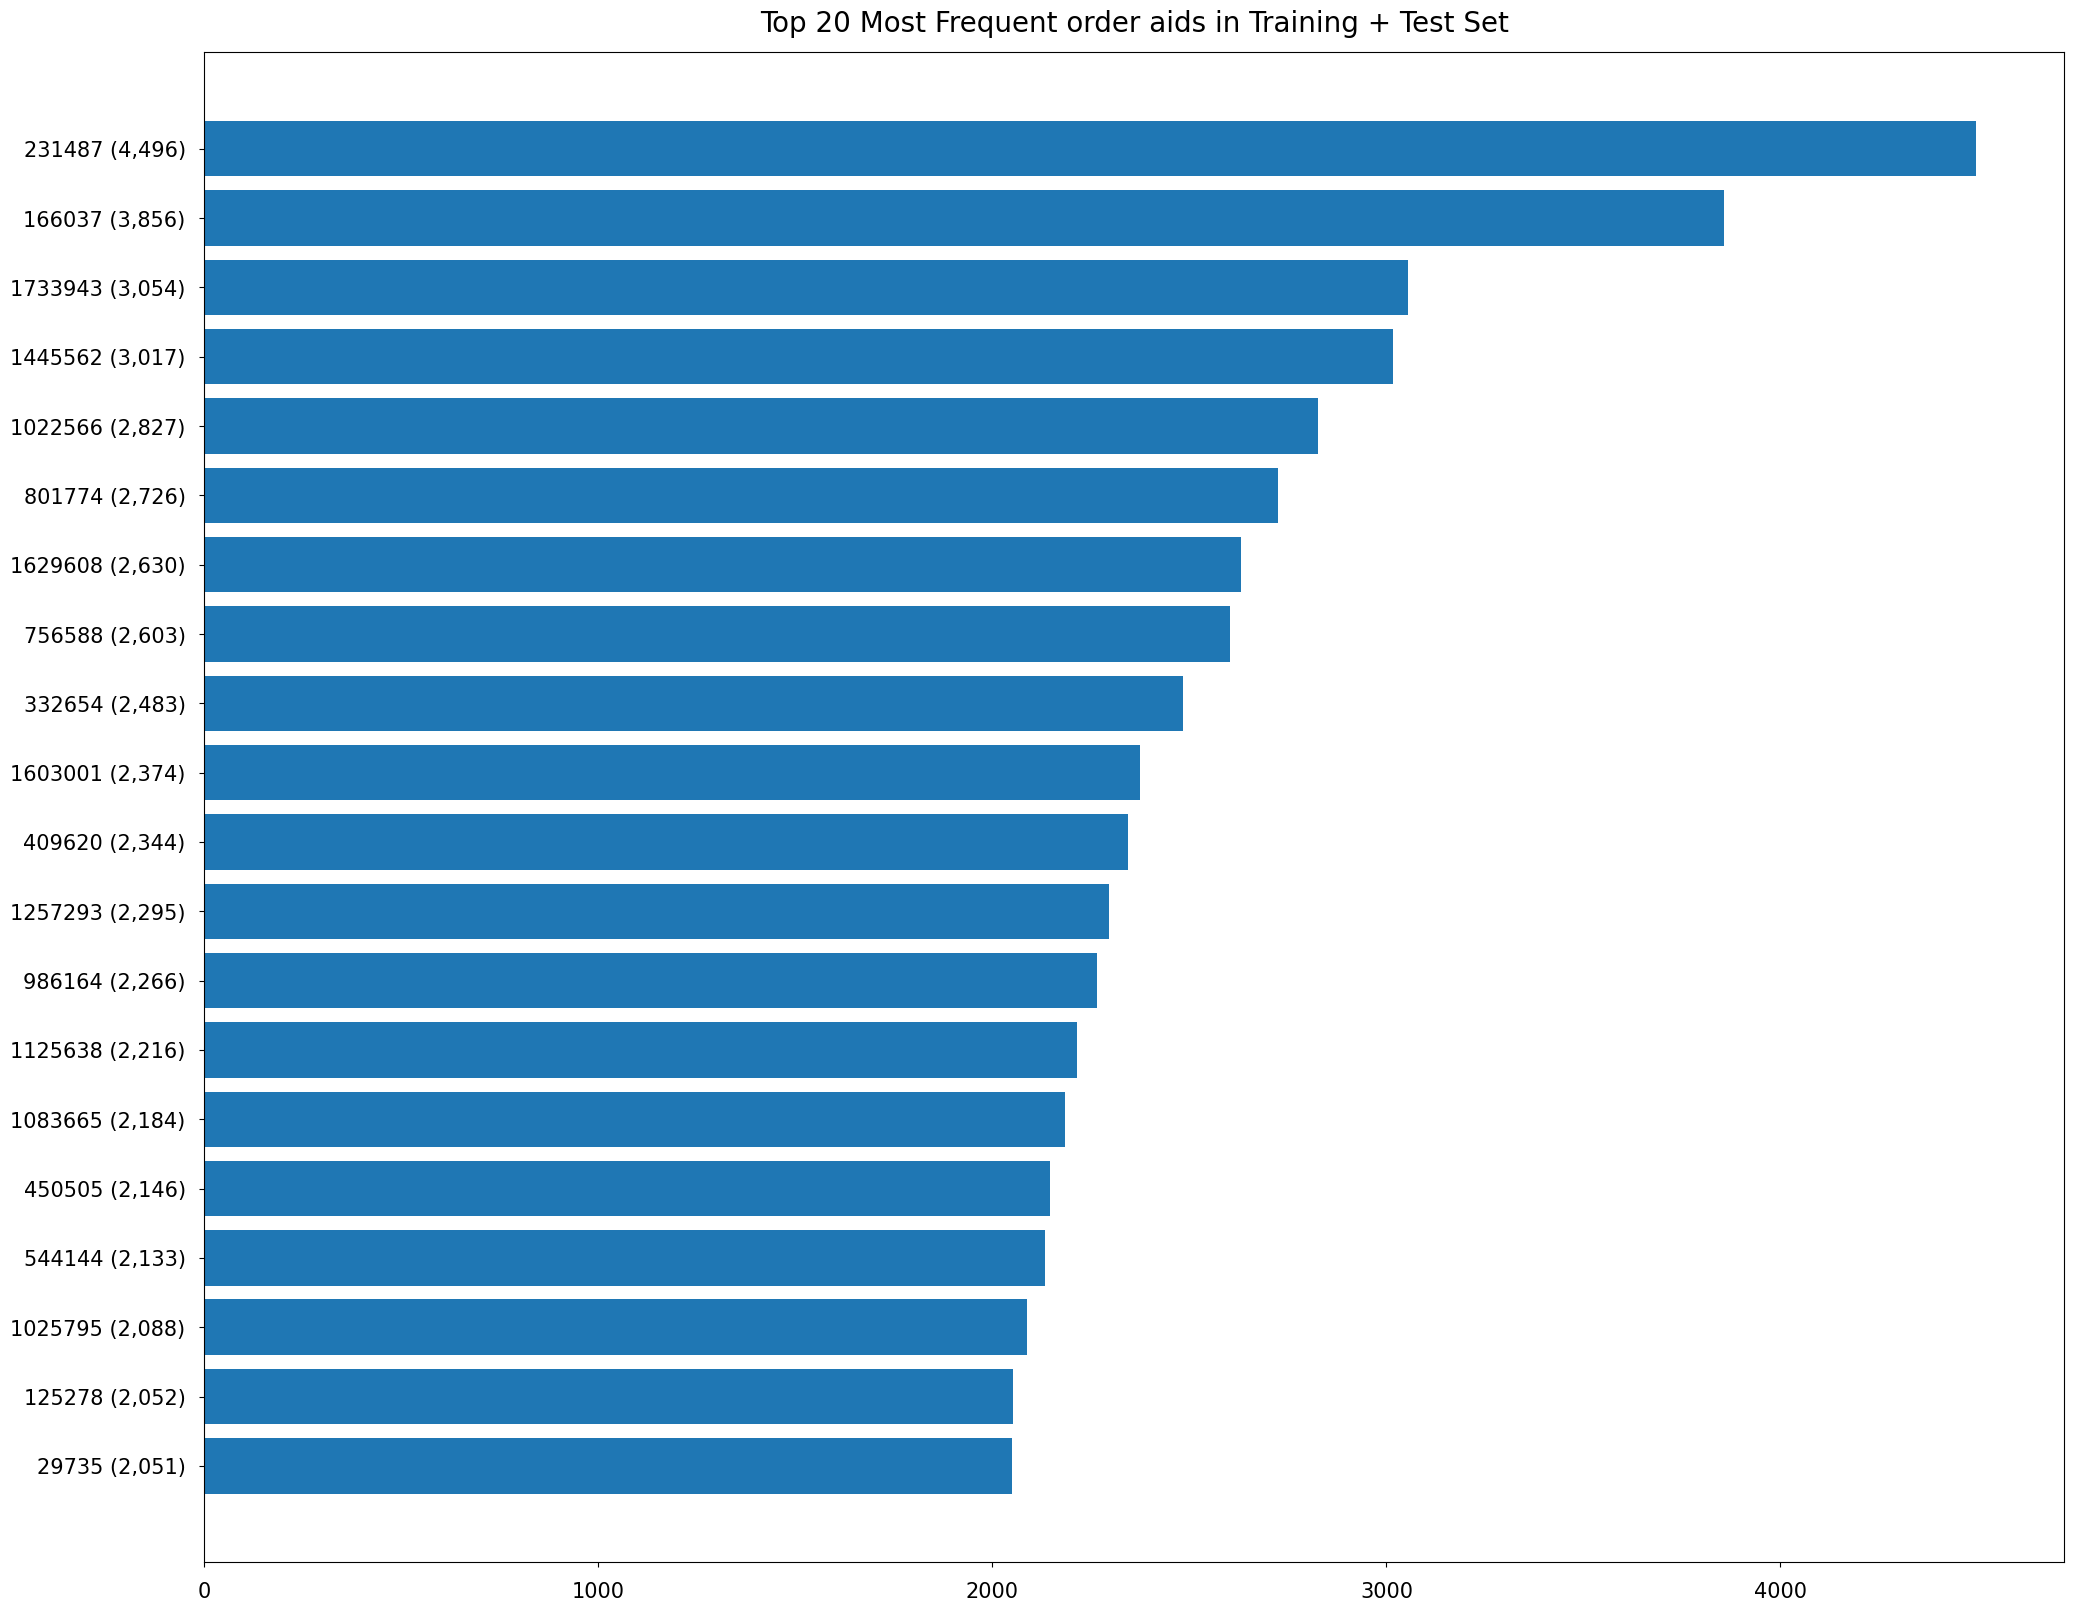

In [13]:
visualize_aid_frequencies(
    aid_frequencies=train_20_most_frequent_order_aids,
    title='Top 20 Most Frequent order aids in Training Set'
)
visualize_aid_frequencies(
    aid_frequencies=test_20_most_frequent_order_aids,
    title='Top 20 Most Frequent order aids in Test Set'
)
visualize_aid_frequencies(
    aid_frequencies=all_20_most_frequent_order_aids,
    title='Top 20 Most Frequent order aids in Training + Test Set'
)

## 4. Events

In training set 93% of sessions are clicks, 16% of sessions are carts and 10% of sessions are orders on average. Those numbers don't add up to 100 because they are averages calculated on all sessions. They have 12, 10 and 8 standard deviations respectively. In test set those numbers are little bit higher for averages and standard deviations because sessions are truncated randomly. Events are likely over/under represented in test sessions.

(0 -> clicks, 1 -> carts, 2 -> orders)

In [14]:
train_session_type_groupby = df_train.groupby(['session', 'type'])
df_train_sessions_types = train_session_type_groupby[['session']].count().rename(columns={'session': 'count'}).reset_index()
df_train_sessions_types['total'] = df_train_sessions_types.groupby('session')['count'].transform('sum')
df_train_sessions_types.sort_values(by=['total', 'session', 'type'], ascending=False, inplace=True)
df_train_sessions_types['rate'] = df_train_sessions_types['count'] / df_train_sessions_types['total']
df_train_sessions_type_rate_means = df_train_sessions_types.groupby('type')['rate'].mean().to_dict()
df_train_sessions_type_rate_stds = df_train_sessions_types.groupby('type')['rate'].std().to_dict()

test_session_type_groupby = df_test.groupby(['session', 'type'])
df_test_sessions_types = test_session_type_groupby[['session']].count().rename(columns={'session': 'count'}).reset_index()
df_test_sessions_types['total'] = df_test_sessions_types.groupby('session')['count'].transform('sum')
df_test_sessions_types.sort_values(by=['total', 'session', 'type'], ascending=False, inplace=True)
df_test_sessions_types['rate'] = df_test_sessions_types['count'] / df_test_sessions_types['total']
df_test_sessions_type_rate_means = df_test_sessions_types.groupby('type')['rate'].mean().to_dict()
df_test_sessions_type_rate_stds = df_test_sessions_types.groupby('type')['rate'].std().to_dict()

print(
f'''
Session Event Type Percentages on Average
Training: 0: {df_train_sessions_type_rate_means[0]:.4f}(±{df_train_sessions_type_rate_stds[0]:.4f}) | 1: {df_train_sessions_type_rate_means[1]:.4f}(±{df_train_sessions_type_rate_stds[1]:.4f}) | 2: {df_train_sessions_type_rate_means[2]:.4f}(±{df_train_sessions_type_rate_stds[2]:.4f})
Test: 0: {df_test_sessions_type_rate_means[0]:.4f}(±{df_test_sessions_type_rate_stds[0]:.4f}) | 1: {df_test_sessions_type_rate_means[1]:.4f}(±{df_test_sessions_type_rate_stds[1]:.4f}) | 2: {df_test_sessions_type_rate_means[2]:.4f}(±{df_test_sessions_type_rate_stds[2]:.4f})
'''
)
del df_train_sessions_type_rate_means, df_train_sessions_type_rate_stds, df_test_sessions_type_rate_means, df_test_sessions_type_rate_stds


Session Event Type Percentages on Average
Training: 0: 0.9375(±0.1231) | 1: 0.1650(±0.1059) | 2: 0.1094(±0.0875)
Test: 0: 0.9573(±0.1189) | 1: 0.2742(±0.1517) | 2: 0.1750(±0.1496)



Some of the sessions might not have any clicks, carts or orders but the statistics below doesn't include their missing event types. The highlight is, some of the sessions in test set can only have clicks, carts or orders, but training set sessions are more heterogeneous. Homogeneous sessions in training set are click-only sessions. This discrepancy could be a problem during modelling.

In [15]:
df_train_sessions_type_rate_mins = df_train_sessions_types.groupby('type')['rate'].min().to_dict()
df_train_sessions_type_rate_maxs = df_train_sessions_types.groupby('type')['rate'].max().to_dict()
df_test_sessions_type_rate_mins = df_test_sessions_types.groupby('type')['rate'].min().to_dict()
df_test_sessions_type_rate_maxs = df_test_sessions_types.groupby('type')['rate'].max().to_dict()

print(
f'''
Session Event Type Least and Most Percentages
Training: 0: {df_train_sessions_type_rate_mins[0]:.4f}-{df_train_sessions_type_rate_maxs[0]:.4f} | 1: {df_train_sessions_type_rate_mins[1]:.4f}-{df_train_sessions_type_rate_maxs[1]:.4f} | 2: {df_train_sessions_type_rate_mins[2]:.4f}-{df_train_sessions_type_rate_maxs[2]:.4f}
Test: 0: {df_test_sessions_type_rate_mins[0]:.4f}-{df_test_sessions_type_rate_maxs[0]:.4f} | 1: {df_test_sessions_type_rate_mins[1]:.4f}-{df_test_sessions_type_rate_maxs[1]:.4f} | 2: {df_test_sessions_type_rate_mins[2]:.4f}-{df_test_sessions_type_rate_maxs[2]:.4f}
'''
)
del df_train_sessions_type_rate_mins, df_train_sessions_type_rate_maxs, df_test_sessions_type_rate_mins, df_test_sessions_type_rate_maxs


Session Event Type Least and Most Percentages
Training: 0: 0.0112-1.0000 | 1: 0.0020-0.9888 | 2: 0.0020-0.9459
Test: 0: 0.0323-1.0000 | 1: 0.0029-1.0000 | 2: 0.0040-1.0000



Another important thing to consider is how sessions start and end. There are two interesting things here. First, sessions are supposed to start with clicks but very few of them start with carts or orders. Those sessions are less than 1% and they might be truncated from their beginning so they could fit into the selected time frame. The other thing is, sessions in test set are less likely to end with an order because of the truncation. Truncated timesteps in test set are more likely order events.  

In [16]:
df_train_session_firsts = (df_train.groupby('session')['type'].first().value_counts() / df_train['session'].nunique()).to_dict()
df_train_session_lasts = (df_train.groupby('session')['type'].last().value_counts() / df_train['session'].nunique()).to_dict()
df_test_session_firsts = (df_test.groupby('session')['type'].first().value_counts() / df_test['session'].nunique()).to_dict()
df_test_session_lasts = (df_test.groupby('session')['type'].last().value_counts() / df_test['session'].nunique()).to_dict()

print(
f'''
Session Event Type First and Last Percentages
Training: 0: {df_train_session_firsts[0]:.4f}-{df_train_session_lasts[0]:.4f} | 1: {df_train_session_firsts[1]:.4f}-{df_train_session_lasts[1]:.4f} | 2: {df_train_session_firsts[2]:.4f}-{df_train_session_lasts[2]:.4f}
Test: 0: {df_test_session_firsts[0]:.4f}-{df_test_session_lasts[0]:.4f} | 1: {df_test_session_firsts[1]:.4f}-{df_test_session_lasts[1]:.4f} | 2: {df_test_session_firsts[2]:.4f}-{df_test_session_lasts[2]:.4f}
'''
)
del df_train_session_firsts, df_train_session_lasts, df_test_session_firsts, df_test_session_lasts


Session Event Type First and Last Percentages
Training: 0: 0.9957-0.9188 | 1: 0.0029-0.0377 | 2: 0.0014-0.0435
Test: 0: 0.9961-0.9398 | 1: 0.0029-0.0507 | 2: 0.0010-0.0094



A natural sequence is clicking to a product, adding it to the cart and ordering it. It can be seen from the visualization of session 3 below that cart events lead to order events multiple times. However, this doesn't apply to all sessions.

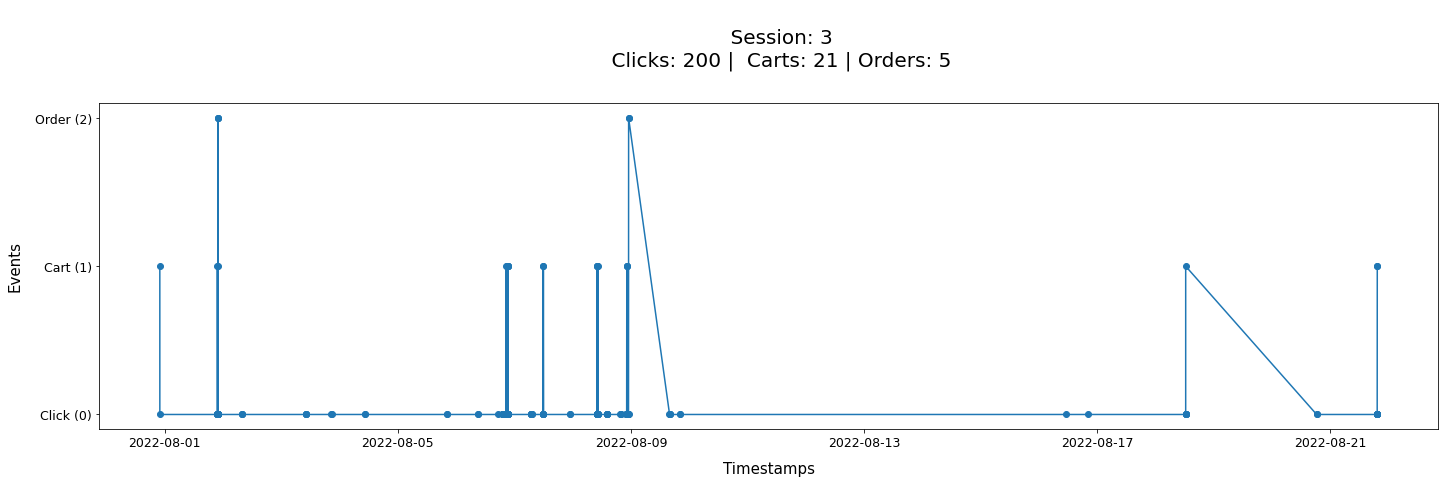

In [17]:
def visualize_session(df, session, path=None):
    
    """
    Visualize given session in given dataframe as a sequence
    
    Parameters
    ----------
    df: pandas.DataFrame of shape (n_samples, 4)
        Training or test dataframe with session, aid, ts, type columns

    feature: int
        Unique ID of the session
    
    path: path-like str or None
        Path of the output file or None (if path is None, plot is displayed with selected backend)
    """
    
    df_session = df.loc[df['session'] == session, :]
    
    fig, ax = plt.subplots(figsize=(24, 6))
    ax.plot(df_session.set_index('ts')['type'], 'o-')
    ax.set_yticks(range(3), ['Click (0)', 'Cart (1)', 'Order (2)'])
    ax.tick_params(axis='x', labelsize=12.5)
    ax.tick_params(axis='y', labelsize=12.5)
    ax.set_xlabel('Timestamps', fontsize=15, labelpad=12.5)
    ax.set_ylabel('Events', fontsize=15, labelpad=12.5)
    title = f'''
    Session: {session}
    Clicks: {(df_session['type'] == 0).sum()} |  Carts: {(df_session['type'] == 1).sum()} | Orders: {(df_session['type'] == 2).sum()}
    '''
    ax.set_title(title, size=20, pad=15)
    
    if path is None:
        plt.show()
    else:
        plt.savefig(path)
        plt.close(fig)


visualize_session(df=df_train, session=3)

In training set, session 39 starts with cart event and session 747 starts with order event which are anomalies mentioned before.

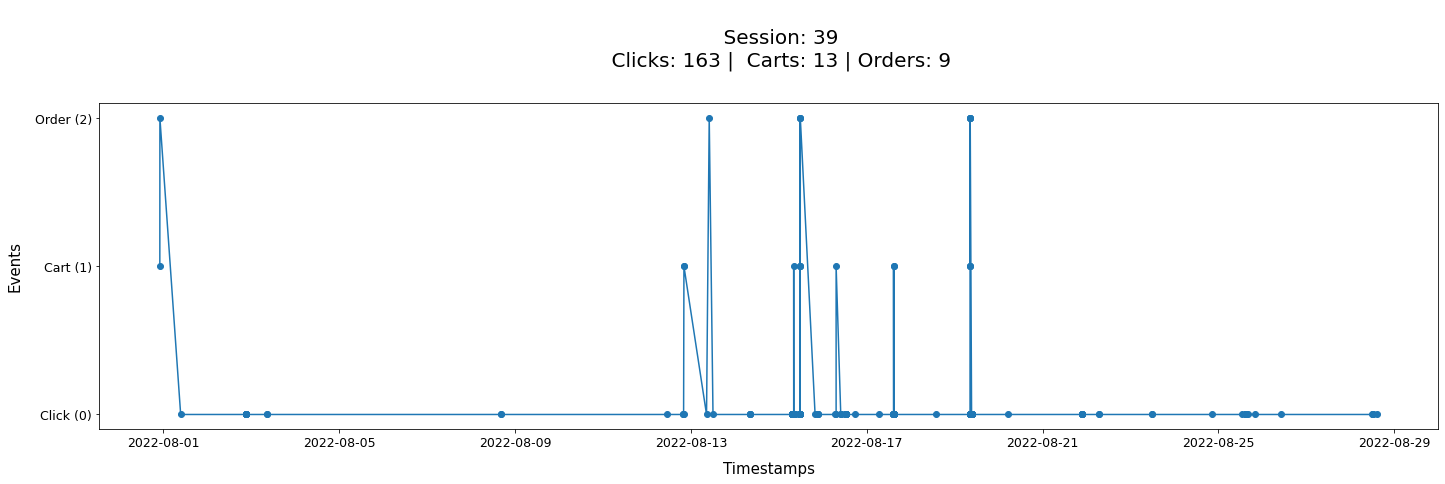

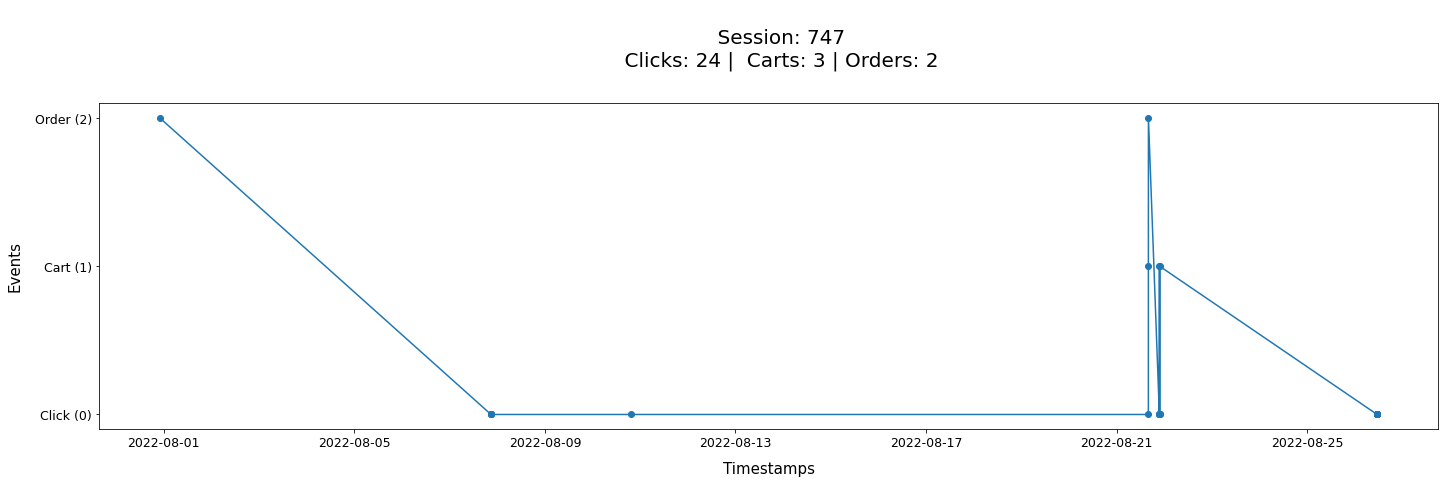

In [18]:
visualize_session(df=df_train, session=39)
visualize_session(df=df_train, session=747)

## 5. Ground-truth

Ground-truth of both training and test set can be created as long as a session has more than 1 timesteps. Ground-truth of clicks and other events are created differently. Ground-truth click of a timestep is the next click in that session. Ground-truth of carts or orders of a timestep is the collection of all next unique carts or orders in that session.

In [19]:
def get_labels(aids, event_types):
    
    """
    Create ground-truth labels from given session aids and event types
    
    Parameters
    ----------
    aids: pandas.Series of shape (n_events)
        Session aids

    event_types: pandas.Series of shape (n_events)
        Session event types
        
    Returns
    -------
    labels: list of shape (n_events)
        Ground-truth labels
    """
    
    previous_click = None
    previous_carts = set()
    previous_orders = set()
    labels = []

    for aid, event_type in zip(reversed(aids.values), reversed(event_types.values)):
        
        label = {}
        
        if event_type == 0:
            previous_click = aid
        elif event_type == 1:
            previous_carts.add(aid)
        elif event_type == 2:
            previous_orders.add(aid)
            
        label[0] = previous_click 
        label[1] = previous_carts.copy() if len(previous_carts) > 0 else np.nan
        label[2] = previous_orders.copy() if len(previous_orders) > 0 else np.nan
        labels.append(label)
        
    labels = labels[:-1][::-1]
    labels.append({0: np.nan, 1: np.nan, 2: np.nan})
    
    return labels


Labels of session 747 are extracted with the function above. It can be seen that after a cart or order event, corresponding aid is dropped from the labels.

In [20]:
df_session747 = df_train.loc[df_train['session'] == 747, :]
session747_labels = get_labels(aids=df_session747['aid'], event_types=df_session747['type'])
df_session747.loc[:, 'label'] = session747_labels
df_session747

,session,aid,ts,type,label
59598,747,522982,2022-07-31 22:00:12.147,2,"{0: 607668, 1: {717801, 33834, 421587}, 2: {71..."
59599,747,607668,2022-08-07 20:51:57.725,0,"{0: 717801, 1: {717801, 33834, 421587}, 2: {71..."
59600,747,717801,2022-08-07 20:52:26.862,0,"{0: 1645078, 1: {717801, 33834, 421587}, 2: {7..."
59601,747,1645078,2022-08-07 20:53:08.458,0,"{0: 607668, 1: {717801, 33834, 421587}, 2: {71..."
59602,747,607668,2022-08-07 20:54:11.982,0,"{0: 384579, 1: {717801, 33834, 421587}, 2: {71..."
59603,747,384579,2022-08-10 19:08:39.562,0,"{0: 717801, 1: {717801, 33834, 421587}, 2: {71..."
59604,747,717801,2022-08-21 16:02:30.571,0,"{0: 522982, 1: {717801, 33834, 421587}, 2: {71..."
59605,747,717801,2022-08-21 16:03:04.516,1,"{0: 522982, 1: {33834, 421587}, 2: {717801}}"
59606,747,717801,2022-08-21 16:04:14.922,2,"{0: 522982, 1: {33834, 421587}, 2: nan}"
59607,747,522982,2022-08-21 21:35:09.880,0,"{0: 1844958, 1: {33834, 421587}, 2: nan}"


## 6. Evaluation

**Precision (positive predictive value)** and **recall (true positive rate)** are most commonly used binary and multi-class classification metrics. Precision formula is TP / (TP + FP) and recall formula is TP / (TP + FN). Predicting less false positives is important for improving precision and predicting more true positives is important for recall. There is always a trade-off between those metrics so harmonic mean of them (F1 score) is also used conjunctly with them.

Those metrics are also used in information retrieval problems. For this problem, predictions are evaluated on recall@20 for each event type and 3 recall values are multiplied with their specified weights. Event type weights are; 0.1 for clicks, 0.3 for carts and 0.6 for orders. Recall makes more sense in this context because false positives aren't important as much as false negatives.

![recall@20](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/Nov-2022/recall.png)

Sessions in test set are truncated by their last events and aids of those truncated events are expected to be predicted. Regardless of the truncated event's type, 20 predictions can be made for clicks, carts and orders. Recalls are calculated separately on those 20 predictions and weighted based on the event type. Finally, 3 recall values are averaged.

For example; let's assume that session 747 is truncated at index 59605 and we are trying to predict aids of that event. 

In [21]:
df_session747.loc[:59605]

,session,aid,ts,type,label
59598,747,522982,2022-07-31 22:00:12.147,2,"{0: 607668, 1: {717801, 33834, 421587}, 2: {71..."
59599,747,607668,2022-08-07 20:51:57.725,0,"{0: 717801, 1: {717801, 33834, 421587}, 2: {71..."
59600,747,717801,2022-08-07 20:52:26.862,0,"{0: 1645078, 1: {717801, 33834, 421587}, 2: {7..."
59601,747,1645078,2022-08-07 20:53:08.458,0,"{0: 607668, 1: {717801, 33834, 421587}, 2: {71..."
59602,747,607668,2022-08-07 20:54:11.982,0,"{0: 384579, 1: {717801, 33834, 421587}, 2: {71..."
59603,747,384579,2022-08-10 19:08:39.562,0,"{0: 717801, 1: {717801, 33834, 421587}, 2: {71..."
59604,747,717801,2022-08-21 16:02:30.571,0,"{0: 522982, 1: {717801, 33834, 421587}, 2: {71..."
59605,747,717801,2022-08-21 16:03:04.516,1,"{0: 522982, 1: {33834, 421587}, 2: {717801}}"


Since there is only one ground-truth for clicks, recall can be either 0 or 1. This can be evaluated by simply using an `in` operation. If ground-truth click aid is in click predictions, then recall is 1. Otherwise, recall is 0. After multiplying the click recall with 0.1, it can be either 0 or 0.1.

In [22]:
def click_recall(y_true, y_pred):
    
    """
    Calculate recall for clicks on ground-truth and predictions
    
    Parameters
    ----------
    y_true: int
        Ground-truth click aid

    y_pred: array-like of shape (n_aids) (1 <= n_aids <= 20)
        Prediction click aids
        
    Returns
    -------
    recall: int
        Recall calculated on ground-truth and predictions
    """
    
    recall = int(y_true in y_pred)
    return recall


session747_click_recall = click_recall(df_session747.loc[59605, 'label'][0] , df_session747.loc[:59605, 'aid'].unique())
print(f'Click Recall of Session 747: {session747_click_recall}')

Click Recall of Session 747: 1


For cart and order event types, there are multiple ground-truth aids so recall can be any value between 0 and 1. Recall of those event types can be calculated with set operations. True positives are the intersection of ground-truth and prediction aids and false negatives are ground-truth - prediction aids.

In some rare cases, number of ground-truth aids can be greater than 20. In order to prevent calculation errors for those cases, denominator should be min(20, n_aids).

In [23]:
def cart_order_recall(y_true, y_pred):
    
    """
    Calculate recall for carts/orders on ground-truth and predictions
    
    Parameters
    ----------
    y_true: array-like of shape (n_aids) (1 <= n_aids)
        Ground-truth cart/order aids

    y_pred: array-like of shape (n_aids) (1 <= n_aids <= 20)
        Prediction cart/order aids
        
    Returns
    -------
    recall: int
        Recall calculated on ground-truth and predictions
    """
    
    y_true = set(y_true)
    y_pred = set(y_pred)
    
    tp = len(y_true.intersection(y_pred))
    fn = len(y_true - y_pred)
    
    recall = tp / min(20, (tp + fn))
    return recall

session747_cart_recall = cart_order_recall(df_session747.loc[59605, 'label'][1] , df_session747.loc[:59605, 'aid'].unique())
print(f'Cart Recall of Session 747: {session747_cart_recall}')
session747_order_recall = cart_order_recall(df_session747.loc[59605, 'label'][2] , df_session747.loc[:59605, 'aid'].unique())
print(f'Order Recall of Session 747: {session747_order_recall}')

Cart Recall of Session 747: 0.0
Order Recall of Session 747: 1.0


After multiplying event type recalls with their weights, recall of session 747 becomes 0.7. Recalls are calculated for each session's truncated last event and averaged which would be the final score.

In [24]:
session_747_recall = (session747_click_recall * 0.1) + (session747_cart_recall * 0.3) + (session747_order_recall * 0.6)
print(f'Recall of Session 747: {session_747_recall}')

Recall of Session 747: 0.7
